In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Sentiment Classification Using RNNs

* Given the IMDB Movie Review Dataset, create an RNN model that predicts whether the given review is negative or positive.
* You need to create your Dataset, Dataloader and Model. Keep your code modular and avoid hardcoding any parameter. This will allow you to experiment more easily.
* Plot graphs for loss and accuracy for each epoch of a training loop. Try using wandb for logging training and validation losses, accuracies (especially for hyperparameter tuning).
* Use tqdm to keep track of the status of the training loop for an epoch.

### 1. RNN Model
#### 1.1 Build a Dataset from the IMDB Movie Review Dataset by taking reviews with word count from 100 to 500. Perform text processing on the movie reviews and create a word to index mapping for representing any review as a list of numbers.


In [12]:
# !pip install datasets torchmetrics

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt

# from datasets import load_dataset
# import re
# from nltk.tokenize import RegexpTokenizer
# from nltk.stem import WordNetLemmatizer

# import torch
# from torch import nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.nn.utils.rnn import pad_sequence
# from torchmetrics import Accuracy

# from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import re, nltk, subprocess, random
from tqdm import tqdm
# import wandb
from sklearn.datasets import load_files

# Load the IMDB dataset
import subprocess

def install_package(package):
    try:
        # Try to import the package
        __import__(package)
    except ImportError:
        # Package is not installed, so try to install it
        subprocess.check_call(["pip", "install", package])

# Usage example:
install_package("datasets")
from datasets import load_dataset
# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

In [15]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


In [16]:
# Split the train set into train and validation in 80-20 split. Use the labels
# to ensure that the ratio of the samples from each label is maintained
# Filter reviews by word count between 100 and 500
def filter_reviews_by_word_count(dataset, min_word_count=100, max_word_count=500):
    filtered_data = []
    for example in dataset:
        text = example["text"]
        word_count = len(text.split())
        if min_word_count <= word_count <= max_word_count:
            filtered_data.append(example)
    return filtered_data

# Filter reviews by word count
train_data = filter_reviews_by_word_count(imdb_dataset["train"])
test_filtered = filter_reviews_by_word_count(imdb_dataset["test"])

# Determine the size of the validation set
val_size = int(0.2 * len(test_filtered))
test_size = len(test_filtered) - val_size

# Randomly select reviews for validation
val_indices = random.sample(range(len(test_filtered)), val_size)
val_data = [test_filtered[i] for i in val_indices]

# Assign the remaining reviews to test_data
test_data = [review for i, review in enumerate(test_filtered) if i not in val_indices]

# Print the sizes of val_data and test_data
print("Size of train_data:", len(train_data))
print("Size of val_data:", len(val_data))
print("Size of test_data:", len(test_data))

Size of train_data: 20056
Size of val_data: 4004
Size of test_data: 16020


In [17]:
# Shuffle the data
np.random.shuffle(train_data)
np.random.shuffle(test_data)
np.random.shuffle(val_data)

# Optionally, limit the size of the datasets
# test_data = test_data[:5000]      # Limiting to 5,000 samples for faster compute

print("Number of samples in train_data:", len(train_data))
print("Number of samples in test_data:", len(test_data))
print("Number of samples in val_data:", len(val_data))


# Function to find the longest sentence
def find_longest_sentence(dataset):
    longest_sentence = ""
    max_length = 0
    for example in dataset:
        text = example["text"]
        if len(text.split()) > max_length:
            longest_sentence = text
            max_length = len(text.split())
    return longest_sentence, max_length  # Return both the longest sentence and its length

# Find longest sentence in each dataset
longest_train_sentence, train_max_length = find_longest_sentence(train_data)
longest_test_sentence, test_max_length = find_longest_sentence(test_data)
longest_val_sentence, val_max_length = find_longest_sentence(val_data)

# Print the longest sentence and its length
print("Longest sentence in train_data:")
print("Number of words:", train_max_length)

print("\nLongest sentence in test_data:")
print("Number of words:", test_max_length)

print("\nLongest sentence in val_data:")
print("Number of words:", val_max_length)


Number of samples in train_data: 20056
Number of samples in test_data: 16020
Number of samples in val_data: 4004
Longest sentence in train_data:
Number of words: 500

Longest sentence in test_data:
Number of words: 500

Longest sentence in val_data:
Number of words: 500


In [18]:
# def clean(text, tokenizer):
#   # Perform text preprocessing:
#   # 1. Removing numbers OR replace them with "num" token
#   # 2. Convert all characters to lowercase.
#   # 3. Tokenize the sentence into words
#   # You can use RegexpTokenizer from NLTK.

#   # You will experiment with stemming/lemmatization down the line
#   # so you can skip that for now

#   return text

In [19]:
# clean("This IS 1 example sentence", RegexpTokenizer(r'\w+'))

In [20]:
nltk.download('punkt')
try:
    nltk.data.find('punkt.zip')
except:
    nltk.download('punkt', download_dir='/kaggle/working/')
    subprocess.run("unzip /usr/share/nltk_data/corpora/punkt.zip -d /usr/share/nltk_data/corpora/".split())
    nltk.data.path.append('/kaggle/input')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /kaggle/working/...
[nltk_data]   Package punkt is already up-to-date!


unzip:  cannot find or open /usr/share/nltk_data/corpora/punkt.zip, /usr/share/nltk_data/corpora/punkt.zip.zip or /usr/share/nltk_data/corpora/punkt.zip.ZIP.


In [21]:
nltk.download('stopwords')
try:
    nltk.data.find('stopwords.zip')
except:
    nltk.download('stopwords', download_dir='/kaggle/working/')
    subprocess.run("unzip /usr/share/nltk_data/corpora/stopwords.zip -d /usr/share/nltk_data/corpora/".split())
    nltk.data.path.append('/kaggle/input')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /kaggle/working/...
[nltk_data]   Package stopwords is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/stopwords.zip


replace /usr/share/nltk_data/corpora/stopwords/dutch? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [22]:
nltk.download('wordnet')
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    subprocess.run("unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/".split())
    nltk.data.path.append('/kaggle/input')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/

In [23]:
# # Text preprocessing
# def preprocess_text(text):
#     text = text.lower()  # Convert to lowercase
#     text = re.sub(r'\W', ' ', text)  # Remove non-word characters
#     text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
#     return text

# # Tokenization and lemmatization
# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))

# def tokenize_and_lemmatize(text):
#     tokens = word_tokenize(text)
#     tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
#     return tokens

In [24]:
# # create a word to index dictionary so that each word in the training set
# # has a number associated with it. This allows to represent each sentence
# # as a series of numbers. Start the index with 1 instead of 0. The number
# # 0 will be used to denote padding, so that each sentence can have the
# # same length.
# # Keep track of the index since it will be used for representing new words
# # that were not part of the training vocabulary.
# # Also, make sure to not create dictionary on sentences with word count
# # not within the range

# def get_word2idx(corpus):
#   idx = 1
#   for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
#     # process sentence
#     sentence = clean(sentence, tokenizer)

#     # drop sentences greater than maxlen or less than minlen

#     # for each word in sentence, check for entry in word2idx

#   return idx, word2idx

In [25]:
# Text preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

def tokenize(text):
    tokens = word_tokenize(text)
#     tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
#     tokens = [porter.stem(word) for word in tokens]
    return tokens

def lemm(tokens, lemmatizer, porter, stop_words):
#     tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
#     tokens = [porter.stem(word) for word in tokens]
    return tokens

def stem(tokens, lemmatizer, porter, stop_words):
#     tokens = word_tokenize(text)
#     tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    tokens = [porter.stem(word) for word in tokens if word not in stop_words]
    return tokens

# Build vocabulary
def build_vocab(data, lemmatizer, porter, stop_words):
    word_to_idx = {}
    idx_to_word = {}
    word_to_idx_stem = {}
    idx_to_word_stem = {}
    word_to_idx_lemm = {}
    idx_to_word_lemm = {}
    for review in data:
        tokens = tokenize(preprocess_text(review['text']))
        tokens_stem = stem(tokens, lemmatizer, porter, stop_words)
        tokens_lemm = lemm(tokens, lemmatizer, porter, stop_words)
        for token in tokens:
            if token not in word_to_idx:
                idx = len(word_to_idx)
                word_to_idx[token] = idx
                idx_to_word[idx] = token
        for token in tokens_stem:
            if token not in word_to_idx_stem:
                idx = len(word_to_idx_stem)
                word_to_idx_stem[token] = idx
                idx_to_word_stem[idx] = token
        for token in tokens_lemm:
            if token not in word_to_idx_lemm:
                idx = len(word_to_idx_lemm)
                word_to_idx_lemm[token] = idx
                idx_to_word_lemm[idx] = token
    
    return word_to_idx, idx_to_word, word_to_idx_stem, idx_to_word_stem, word_to_idx_lemm, idx_to_word_lemm



In [26]:
# Tokenization and lemmatization
lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Modify the code according to train, test, val datasets
word_to_idx_train, idx_to_word_train, word_to_idx_stem_train, idx_to_word_stem_train, word_to_idx_lemm_train, idx_to_word_lemm_train = build_vocab(train_data, lemmatizer, porter, stop_words)

# Find a unique index for UNK
max_idx = max(word_to_idx_train.values()) if word_to_idx_train else -1
unk_idx = max_idx + 1

# Find a unique index for UNK
max_idx_stem = max(word_to_idx_stem_train.values()) if word_to_idx_stem_train else -1
unk_idx_stem = max_idx_stem + 1

# Find a unique index for UNK
max_idx_lemm = max(word_to_idx_lemm_train.values()) if word_to_idx_lemm_train else -1
unk_idx_lemm = max_idx_lemm + 1

# Add UNK to word_to_idx_train
word_to_idx_train['UNK'] = unk_idx
word_to_idx_stem_train['UNK'] = unk_idx_stem
word_to_idx_lemm_train['UNK'] = unk_idx_lemm

#### 1.2 Create Dataloaders for the train, test and validation datasets with appropriate batch sizes.


In [27]:
# # Build a Dataset object to store each sentence as a tensor of numbers
# # along with the label. Make sure to add padding so that the tensor
# # for each sentence is of the same length. This will allow us to train
# # the model in batches.

# class IMDBDataset(Dataset):
#   def __init__(self, dataset, split : str, minlen : int = 100, maxlen : int = 500):
#     self.count = 0 # total sentences you finally pick

#     # count total number of lines
#     len = len(dataset[split])

#     input_data = []
#     target_data = []

#     for idx, sentence in tqdm(enumerate(corpus), total=len, desc=f"Transforming input text [{split}]"):
#       # process sentence

#       # drop sentences greater than maxlen or less than minlen

#       # replace words with their index


#       self.count += 1

#     # pad the sentences upto maxlen
#     self.inputs = pad_sequence(input_data, batch_first = True)
#     self.targets = torch.tensor(target_data)

#   def __len__(self) -> int:
#     return self.count

#   def __getitem__(self, index : int):
#     return self.inputs[index], self.targets[index]

In [28]:
# # create the train dataset using the word2idx dictionary built using the train set
# train_ds = IMDBDataset(imdb_dataset, "train",minlen = 100, maxlen = 500)
# # create the validation and test dataset using the word2idx dictionary built using the train set



In [29]:
# len(train_ds), len(val_ds), len(test_ds)

In [30]:
# # create dataloaders using the dataset
# params = {
#     'batch_size':32,
#     'shuffle': True,
#     'num_workers': 2
# }

# train_dataloader = DataLoader(train_ds, **params)
# test_dataloader = DataLoader(val_ds, **params)
# test_dataloader = DataLoader(test_ds, **params)

In [31]:
class IMDBDataset(Dataset):
    def __init__(self, data, word_to_idx, max_length=500):
        self.data = data
        self.word_to_idx = word_to_idx
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        review = self.data[index]['text']
        label = int(self.data[index]['label'])  # Convert label to integer
        tokens = tokenize(preprocess_text(review))
        indexed_tokens = [self.word_to_idx.get(token, max_idx + 1) for token in tokens]  # Use .get() to handle missing keys
        indexed_tokens = indexed_tokens[:self.max_length]  # Trim to max length
        padded_tokens = indexed_tokens + [0] * (self.max_length - len(indexed_tokens))  # Pad sequence
        return torch.tensor(padded_tokens), torch.tensor(label)

    
class IMDBDataset_stem(Dataset):
    def __init__(self, data, word_to_idx_stem, max_length=500):
        self.data = data
        self.word_to_idx_stem = word_to_idx_stem
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        review = self.data[index]['text']
        label = int(self.data[index]['label'])  # Convert label to integer
        tokens_stem = stem(tokenize(preprocess_text(review)), lemmatizer, porter, stop_words)
        indexed_tokens_stem = [self.word_to_idx_stem.get(token_stem, max_idx_stem + 1) for token_stem in tokens_stem]  # Use .get() to handle missing keys
        indexed_tokens_stem = indexed_tokens_stem[:self.max_length]  # Trim to max length
        padded_tokens_stem = indexed_tokens_stem + [0] * (self.max_length - len(indexed_tokens_stem))  # Pad sequence
        return torch.tensor(padded_tokens_stem), torch.tensor(label)

    
class IMDBDataset_lemm(Dataset):
    def __init__(self, data, word_to_idx_lemm, max_length=500):
        self.data = data
        self.word_to_idx_lemm = word_to_idx_lemm
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        review = self.data[index]['text']
        label = int(self.data[index]['label'])  # Convert label to integer
        tokens_lemm = lemm(tokenize(preprocess_text(review)), lemmatizer, porter, stop_words)
        indexed_tokens_lemm = [self.word_to_idx_lemm.get(token_lemm, max_idx_lemm + 1) for token_lemm in tokens_lemm]  # Use .get() to handle missing keys
        indexed_tokens_lemm = indexed_tokens_lemm[:self.max_length]  # Trim to max length
        padded_tokens_lemm = indexed_tokens_lemm + [0] * (self.max_length - len(indexed_tokens_lemm))  # Pad sequence
        return torch.tensor(padded_tokens_lemm), torch.tensor(label)


In [32]:
# Create DataLoader
def collate_fn(batch):
    inputs = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels = torch.tensor(labels)
    return padded_inputs, labels


In [33]:
# Function to create dataset and data loader
def create_dataset_and_loader(data, word_to_idx, batch_size, shuffle):
    dataset = IMDBDataset(data, word_to_idx)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
    return dataset, loader


# Function to create dataset and data loader
def create_dataset_and_loader_stem(data, word_to_idx_stem, batch_size, shuffle):
    dataset_stem = IMDBDataset_stem(data, word_to_idx_stem)
    loader_stem = DataLoader(dataset_stem, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
    return dataset_stem, loader_stem


# Function to create dataset and data loader
def create_dataset_and_loader_lemm(data, word_to_idx_lemm, batch_size, shuffle):
    dataset_lemm = IMDBDataset_lemm(data, word_to_idx_lemm)
    loader_lemm = DataLoader(dataset_lemm, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
    return dataset_lemm, loader_lemm

In [34]:
batch_size = 32

train_dataset, train_loader = create_dataset_and_loader(train_data, word_to_idx_train, batch_size, shuffle=True)
val_dataset, val_loader = create_dataset_and_loader(val_data, word_to_idx_train, batch_size, shuffle=False)
test_dataset, test_loader = create_dataset_and_loader(test_data, word_to_idx_train, batch_size, shuffle=False)

# Print the lengths of datasets
print("Length of train_dataset:", len(train_dataset))
print("Length of val_dataset:", len(val_dataset))
print("Length of test_dataset:", len(test_dataset))


train_dataset_stem, train_loader_stem = create_dataset_and_loader_stem(train_data, word_to_idx_stem_train, batch_size, shuffle=True)
val_dataset_stem, val_loader_stem = create_dataset_and_loader_stem(val_data, word_to_idx_stem_train, batch_size, shuffle=False)
test_dataset_stem, test_loader_stem = create_dataset_and_loader_stem(test_data, word_to_idx_stem_train, batch_size, shuffle=False)

# Print the lengths of datasets
print("Length of train_dataset:", len(train_dataset_stem))
print("Length of val_dataset:", len(val_dataset_stem))
print("Length of test_dataset:", len(test_dataset_stem))


train_dataset_lemm, train_loader_lemm = create_dataset_and_loader_lemm(train_data, word_to_idx_lemm_train, batch_size, shuffle=True)
val_dataset_lemm, val_loader_lemm = create_dataset_and_loader_lemm(val_data, word_to_idx_lemm_train, batch_size, shuffle=False)
test_dataset_lemm, test_loader_lemm = create_dataset_and_loader_lemm(test_data, word_to_idx_lemm_train, batch_size, shuffle=False)

# Print the lengths of datasets
print("Length of train_dataset:", len(train_dataset_lemm))
print("Length of val_dataset:", len(val_dataset_lemm))
print("Length of test_dataset:", len(test_dataset_lemm))

Length of train_dataset: 20056
Length of val_dataset: 4004
Length of test_dataset: 16020
Length of train_dataset: 20056
Length of val_dataset: 4004
Length of test_dataset: 16020
Length of train_dataset: 20056
Length of val_dataset: 4004
Length of test_dataset: 16020


#### 1.3 Create the Model class for the RNN Model. Create functions for running model training and testing.

In [35]:
# # create a model
# class RNNModel(nn.Module):
#   def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
#     # call the init method of the parent

#     # define the layers


#   def forward(self, X):

#     # run foward pass through the model

#     return logits

In [36]:
# # Hyperparameters
# hidden_size = 256
# embedding_dim = 128
# learning_rate = 1e-3
# epochs = 5

# # create the model
# model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

# # create optimizer

# print(model)

In [37]:
# # Create a model training loop
# def train_model():

#   for epoch in range(epochs):
#     ## TRAINING STEP
#     model.train()
#     # train
#     for input_batch, output_batch in tqdm(trainloader, total = len(trainloader), desc = "Training"):

#     # Log metrics

#     ## VALIDATION STEP
#     model.eval()
#     # run validation
#     for input_batch, output_batch in tqdm(valloader, total = len(valloader), desc = "Validation"):

#     # Log metrics

#     # store best model

#   return train_losses, val_losses, val_accuracy

In [166]:
# Create a model testing loop


In [167]:
# # train the model
# train_losses, val_losses, val_accuracy = train_model()

In [168]:
# plot training and validation losses

In [169]:
# plot validation accuracy

In [170]:
# find the classification accuracy on test set


In [171]:
class RNN1(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, output_size):
        super(RNN1, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Output size is 1 for binary classification
        self.hidden_size = hidden_size

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        # Take the output from the last time step of the last layer
#         last_output = output[:, -1, :]
#         return output.squeeze(1)  # Ensure output shape is [batch_size]
#         output = output.contiguous().view(-1, self.hidden_size)
        logits = self.fc(hidden[-1])
#         print(logits.size())
        return logits


In [172]:
# # Training function
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
#     model.to(device)
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)  # Convert labels to float and unsqueeze to add a dimension
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)  # View labels as the same shape as outputs
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * inputs.size(0)

#         train_loss /= len(train_loader.dataset)

#         # Validation
#         model.eval()
#         val_loss = 0.0
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)  # Convert labels to float and unsqueeze to add a dimension
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)  # View labels as the same shape as outputs
#                 val_loss += loss.item() * inputs.size(0)

#                 # Apply sigmoid activation for BCE
#                 predicted = torch.round(torch.sigmoid(outputs))

#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         val_loss /= len(val_loader.dataset)
#         val_accuracy = correct / total

#         print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_accuracy}')

# # Testing function
# def test_model(model, test_loader, device):
#     model.to(device)
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)  # Convert labels to float and unsqueeze to add a dimension
#             outputs = model(inputs)
#             predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid activation and round to get predictions
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     test_accuracy = correct / total
#     print(f'Test Accuracy: {test_accuracy}')

In [173]:
# Hyperparameters
embedding_size = 100
hidden_size = 128
num_layers = 1
output_size = 1  # For binary classification
learning_rate = 0.005
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# input_size = len(word_to_idx_train)


In [174]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        for inputs, labels in progress_bar_train:
#             print(inputs.size(), labels.size())
            inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
#             print(outputs.size(), labels.size())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
#             progress_bar_train.set_postfix({'train_loss': train_loss / len(train_loader.dataset)})
            
            # Calculate training accuracy
            predicted_train = torch.round(torch.sigmoid(outputs))
#             _, predicted_train = torch.max(outputs, 1)
    
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
#             print(predicted_train)
#             print(labels) 
#             print(correct_train)
#             break
            
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
            for inputs, labels in progress_bar_val:
                inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                predicted_val = torch.round(torch.sigmoid(outputs))
#                 _, predicted_val = torch.max(outputs, 1)
    
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_accuracy}')

    # Plot the losses and accuracies
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.xticks(range(1, num_epochs + 1))

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.xticks(range(1, num_epochs + 1))

    plt.tight_layout()
    plt.show()

    

# Testing function
def test_model(model, test_loader, device):
    model.to(device)
    model.eval()
#     test_accuracies = []
    correct = 0
    total = 0
    with torch.no_grad():
        progress_bar_test = tqdm(test_loader, desc='Testing')
        for inputs, labels in progress_bar_test:
            inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs))
#             _, predicted = torch.max(outputs, 1)
    
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
#             test_accuracies.append(correct / total)
    
#     # Plotting the testing accuracy graph
#     plt.figure(figsize=(10, 5))
#     plt.plot(test_accuracies, marker='o', label='Test Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Testing Accuracy')
#     plt.legend()plt.xticks(range(1, num_epochs + 1))
#     plt.show()

#     return test_accuracies
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy}')


In [175]:
def ModelToRun1(input_size, embedding_size, hidden_size, num_layers, output_size, device, train_loader, val_loader, num_epochs, test_loader):
    # Initialize model, criterion, and optimizer
    model1 = RNN1(input_size, embedding_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits
    optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
    # Train the model2
    train_model(model1, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    # Test the model
    test_model(model1, test_loader, device)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:08<00:00, 14.27it/s]


Epoch 1/5, Train Loss: 0.703516985654926, Val Loss: 0.6988624644565297, Val Acc: 0.4857642357642358


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:08<00:00, 14.22it/s]


Epoch 2/5, Train Loss: 0.7011648772672966, Val Loss: 0.7181377223321608, Val Acc: 0.48451548451548454


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:08<00:00, 14.16it/s]


Epoch 3/5, Train Loss: 0.7030505577929238, Val Loss: 0.6961819838572454, Val Acc: 0.4857642357642358


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.71it/s]


Epoch 4/5, Train Loss: 0.6987576757144967, Val Loss: 0.6937429278523296, Val Acc: 0.5157342657342657


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:08<00:00, 14.09it/s]


Epoch 5/5, Train Loss: 0.6992554781586229, Val Loss: 0.7168929661427821, Val Acc: 0.5152347652347652


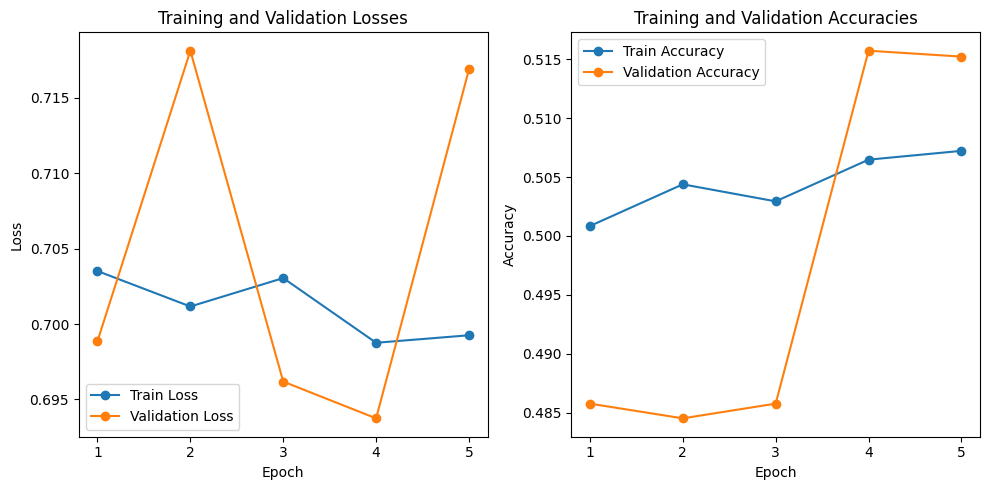

Testing: 100%|██████████| 501/501 [00:35<00:00, 14.21it/s]

Test Accuracy: 0.5090511860174781


In [176]:
ModelToRun1(len(word_to_idx_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader, val_loader, num_epochs, test_loader)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:23<00:00,  5.32it/s]


Epoch 1/5, Train Loss: 0.7073740248286396, Val Loss: 0.6966590237665129, Val Acc: 0.5137362637362637


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:23<00:00,  5.30it/s]


Epoch 2/5, Train Loss: 0.7082498560495761, Val Loss: 0.7005386646691855, Val Acc: 0.5137362637362637


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:23<00:00,  5.26it/s]


Epoch 3/5, Train Loss: 0.7031180127521982, Val Loss: 0.6944983178799922, Val Acc: 0.48626373626373626


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:23<00:00,  5.34it/s]


Epoch 4/5, Train Loss: 0.7029823012973951, Val Loss: 0.6988989091538763, Val Acc: 0.5137362637362637


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:23<00:00,  5.31it/s]


Epoch 5/5, Train Loss: 0.7035392281730478, Val Loss: 0.7106208084941982, Val Acc: 0.48626373626373626


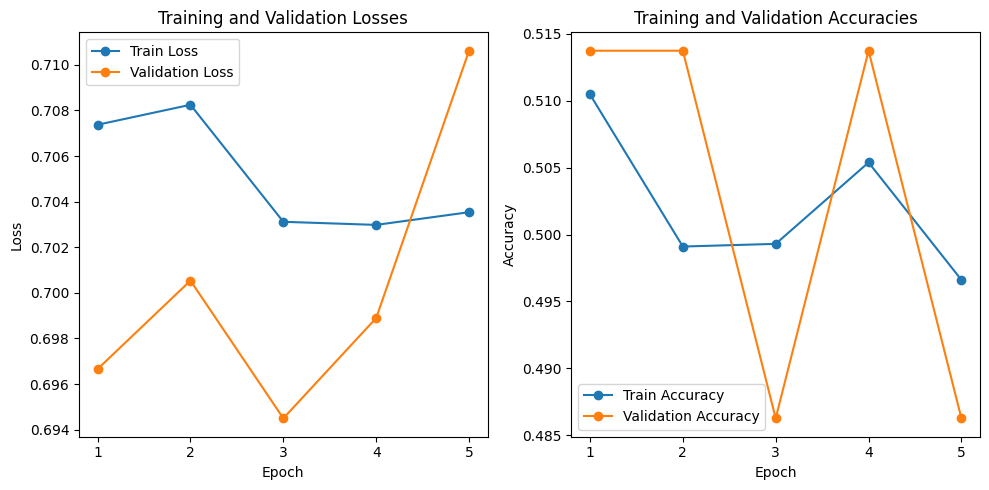

Testing: 100%|██████████| 501/501 [01:37<00:00,  5.14it/s]

Test Accuracy: 0.49219725343320847


In [177]:
ModelToRun1(len(word_to_idx_stem_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader_stem, val_loader_stem, num_epochs, test_loader_stem)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.94it/s]


Epoch 1/5, Train Loss: 0.7038307407723036, Val Loss: 0.7172609025781805, Val Acc: 0.48626373626373626


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.76it/s]


Epoch 2/5, Train Loss: 0.7039295648929366, Val Loss: 0.6965125000083839, Val Acc: 0.48626373626373626


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.82it/s]


Epoch 3/5, Train Loss: 0.7062034480449066, Val Loss: 0.6939699627779105, Val Acc: 0.5137362637362637


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.94it/s]


Epoch 4/5, Train Loss: 0.70159694484662, Val Loss: 0.7005360754100712, Val Acc: 0.5137362637362637


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.79it/s]


Epoch 5/5, Train Loss: 0.7010467187741101, Val Loss: 0.6969767763659909, Val Acc: 0.48626373626373626


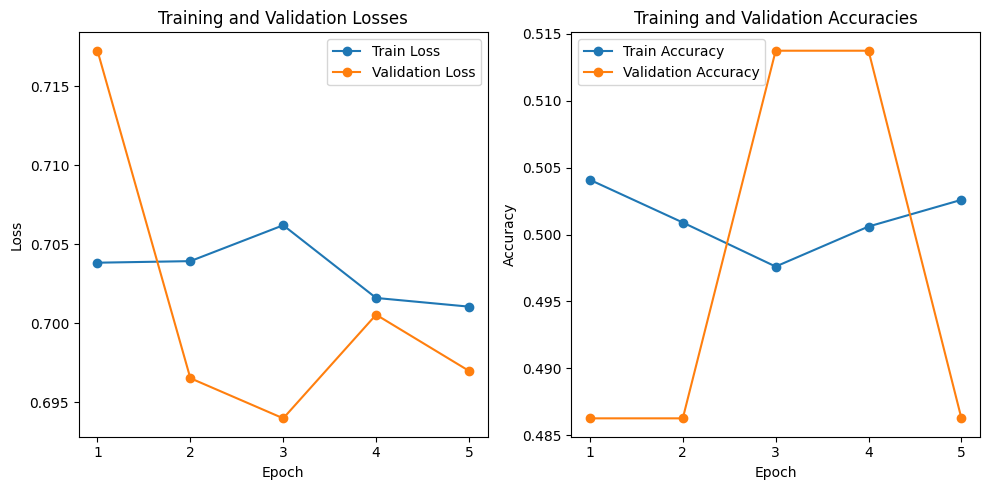

Testing: 100%|██████████| 501/501 [00:46<00:00, 10.81it/s]

Test Accuracy: 0.49219725343320847


In [178]:
ModelToRun1(len(word_to_idx_lemm_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader_lemm, val_loader_lemm, num_epochs, test_loader_lemm)

In [179]:
class RNN2(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, output_size):
        super(RNN2, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Output size is 1 for binary classification

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        # Take the output from the last time step of the last layer
        last_output = output[:, -1, :]
        output = self.fc(last_output)
        return output.squeeze(1)  # Ensure output shape is [batch_size]
#         output = output.contiguous().view(-1, self.hidden_size)
#         output = self.fc(output)
#         return output


In [180]:
# Hyperparameters
embedding_size = 100
hidden_size = 128
num_layers = 1
output_size = 1  # For binary classification
learning_rate = 0.005
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# input_size = len(word_to_idx_train)


In [181]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        for inputs, labels in progress_bar_train:
            inputs, labels = inputs.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
#             progress_bar_train.set_postfix({'train_loss': train_loss / len(train_loader.dataset)})
            
            # Calculate training accuracy
            predicted_train = torch.round(torch.sigmoid(outputs))
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
            for inputs, labels in progress_bar_val:
                inputs, labels = inputs.to(device), labels.float().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                predicted_val = torch.round(torch.sigmoid(outputs))

                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_accuracy}')

    # Plot the losses and accuracies
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.xticks(range(1, num_epochs + 1))

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.xticks(range(1, num_epochs + 1))

    plt.tight_layout()
    plt.show()

    

# Testing function
def test_model(model, test_loader, device):
    model.to(device)
    model.eval()
#     test_accuracies = []
    correct = 0
    total = 0
    with torch.no_grad():
        progress_bar_test = tqdm(test_loader, desc='Testing')
        for inputs, labels in progress_bar_test:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
#             test_accuracies.append(correct / total)
    
#     # Plotting the testing accuracy graph
#     plt.figure(figsize=(10, 5))
#     plt.plot(test_accuracies, marker='o', label='Test Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Testing Accuracy')
#     plt.legend()plt.xticks(range(1, num_epochs + 1))
#     plt.show()

#     return test_accuracies
    test_accuracy = correct / total  
    print(f'Test Accuracy: {test_accuracy}')


In [182]:
def ModelToRun2(input_size, embedding_size, hidden_size, num_layers, output_size, device, train_loader, val_loader, num_epochs, test_loader):
    # Initialize model, criterion, and optimizer
    model2 = RNN2(input_size, embedding_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits
    optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
    # Train the model2
    train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    # Test the model
    test_model(model2, test_loader, device)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:08<00:00, 14.33it/s]


Epoch 1/5, Train Loss: 0.706908713549221, Val Loss: 0.7037522985742285, Val Acc: 0.514985014985015


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:08<00:00, 14.34it/s]


Epoch 2/5, Train Loss: 0.706750280171407, Val Loss: 0.7017073354997359, Val Acc: 0.4852647352647353


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:08<00:00, 14.28it/s]


Epoch 3/5, Train Loss: 0.7064479394504926, Val Loss: 0.7044692102607552, Val Acc: 0.4857642357642358


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:08<00:00, 14.26it/s]


Epoch 4/5, Train Loss: 0.6980908408695642, Val Loss: 0.6957704450462486, Val Acc: 0.512987012987013


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:08<00:00, 14.21it/s]


Epoch 5/5, Train Loss: 0.7000866146452835, Val Loss: 0.7352741470227351, Val Acc: 0.5137362637362637


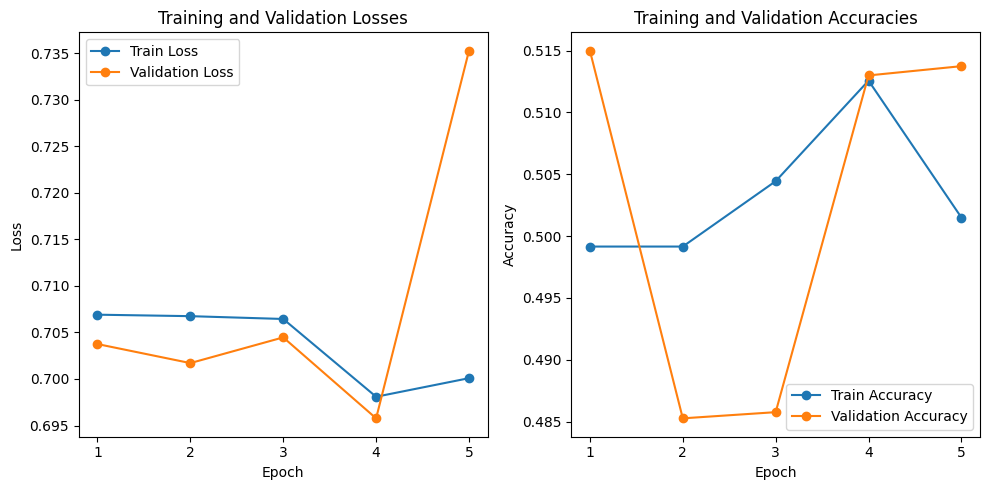

Testing: 100%|██████████| 501/501 [00:35<00:00, 14.12it/s]

Test Accuracy: 0.5078027465667915


In [183]:
ModelToRun2(len(word_to_idx_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader, val_loader, num_epochs, test_loader)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:23<00:00,  5.30it/s]


Epoch 1/5, Train Loss: 0.705061338981595, Val Loss: 0.7265724795205253, Val Acc: 0.48626373626373626


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.22it/s]


Epoch 2/5, Train Loss: 0.7022300725397856, Val Loss: 0.692819140650533, Val Acc: 0.5137362637362637


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.24it/s]


Epoch 3/5, Train Loss: 0.7043350822287439, Val Loss: 0.7018966400301778, Val Acc: 0.48626373626373626


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.20it/s]


Epoch 4/5, Train Loss: 0.7058371141891723, Val Loss: 0.6928657571990768, Val Acc: 0.5137362637362637


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.17it/s]


Epoch 5/5, Train Loss: 0.7058460041969765, Val Loss: 0.7471216296578025, Val Acc: 0.48626373626373626


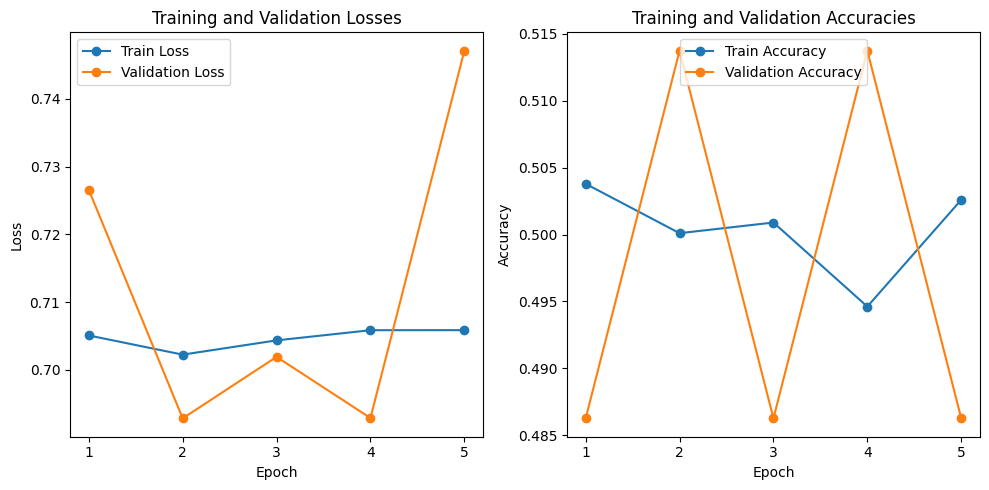

Testing: 100%|██████████| 501/501 [01:37<00:00,  5.16it/s]

Test Accuracy: 0.49219725343320847


In [184]:
ModelToRun2(len(word_to_idx_stem_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader_stem, val_loader_stem, num_epochs, test_loader_stem)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.76it/s]


Epoch 1/5, Train Loss: 0.7034755980393114, Val Loss: 0.7250040637386905, Val Acc: 0.48626373626373626


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.76it/s]


Epoch 2/5, Train Loss: 0.7042423816472827, Val Loss: 0.6948388862562227, Val Acc: 0.5137362637362637


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.70it/s]


Epoch 3/5, Train Loss: 0.7018843262044376, Val Loss: 0.7276049249774807, Val Acc: 0.48626373626373626


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.62it/s]


Epoch 4/5, Train Loss: 0.7056813027975709, Val Loss: 0.7001465252943925, Val Acc: 0.48626373626373626


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.67it/s]


Epoch 5/5, Train Loss: 0.7012195228151368, Val Loss: 0.692925318673655, Val Acc: 0.5137362637362637


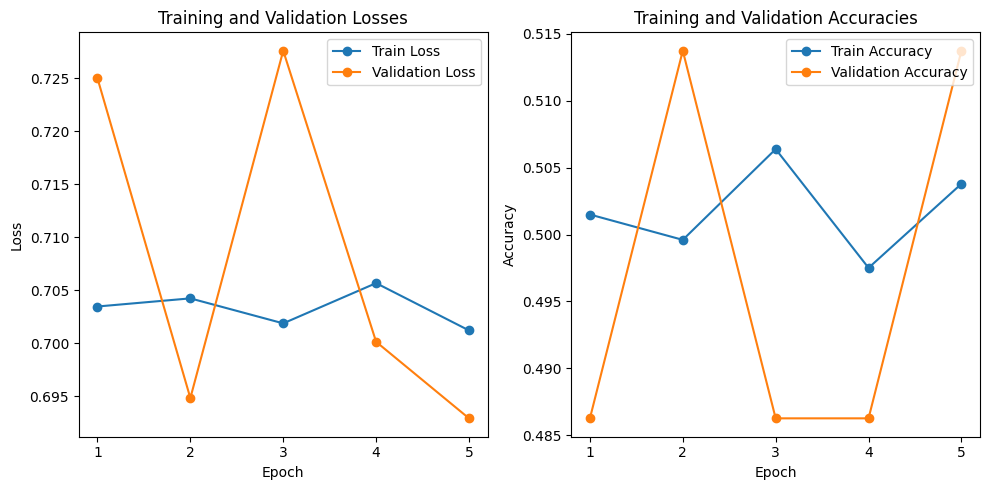

Testing: 100%|██████████| 501/501 [00:47<00:00, 10.51it/s]

Test Accuracy: 0.5078027465667915


In [185]:
ModelToRun2(len(word_to_idx_lemm_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader_lemm, val_loader_lemm, num_epochs, test_loader_lemm)

In [186]:
class RNN3(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, output_size):
        super(RNN3, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Output size is 1 for binary classification

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output_mean = torch.mean(output, dim=1)
        output = self.fc(output_mean)
        return output.squeeze(1)  # Ensure output shape is [batch_size]

In [187]:
# # Training function
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
#     model.to(device)
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.float().to(device)  # Convert labels to float
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * inputs.size(0)

#         train_loss /= len(train_loader.dataset)

#         # Validation
#         model.eval()
#         val_loss = 0.0
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.float().to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item() * inputs.size(0)

#                 # Apply sigmoid activation and round to get predictions
#                 predicted = torch.round(torch.sigmoid(outputs))

#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         val_loss /= len(val_loader.dataset)
#         val_accuracy = correct / total

#         print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_accuracy}')


# # Testing function
# def test_model(model, test_loader, device):
#     model.to(device)
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.float().to(device)  # Convert labels to float
#             outputs = model(inputs)
#             predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid activation and round to get predictions
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     test_accuracy = correct / total
#     print(f'Test Accuracy: {test_accuracy}')

In [188]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        for inputs, labels in progress_bar_train:
            inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
#             progress_bar_train.set_postfix({'train_loss': train_loss / len(train_loader.dataset)})
            
            # Calculate training accuracy
            predicted_train = torch.round(torch.sigmoid(outputs))
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
            for inputs, labels in progress_bar_val:
                inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                predicted_val = torch.round(torch.sigmoid(outputs))

                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_accuracy}')

    # Plot the losses and accuracies
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.xticks(range(1, num_epochs + 1))

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.xticks(range(1, num_epochs + 1))

    plt.tight_layout()
    plt.show()


    

# Testing function
def test_model(model, test_loader, device):
    model.to(device)
    model.eval()
#     test_accuracies = []
    correct = 0
    total = 0
    with torch.no_grad():
        progress_bar_test = tqdm(test_loader, desc='Testing')
        for inputs, labels in progress_bar_test:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
#             test_accuracies.append(correct / total)
    
#     # Plotting the testing accuracy graph
#     plt.figure(figsize=(10, 5))
#     plt.plot(test_accuracies, marker='o', label='Test Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Testing Accuracy')
#     plt.legend()plt.xticks(range(1, num_epochs + 1))
#     plt.show()

#     return test_accuracies
    test_accuracy = correct / total  
    print(f'Test Accuracy: {test_accuracy}')


In [189]:
# Hyperparameters
embedding_size = 100
hidden_size = 128
num_layers = 1
output_size = 1  # For binary classification
learning_rate = 0.005
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# input_size = len(word_to_idx_train)



In [190]:
def ModelToRun3(input_size, embedding_size, hidden_size, num_layers, output_size, device, train_loader, val_loader, num_epochs, test_loader):
    # Initialize model, criterion, and optimizer
    model3 = RNN3(input_size, embedding_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits
    optimizer = optim.Adam(model3.parameters(), lr=learning_rate)
    # Train the model2
    train_model(model3, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    # Test the model
    test_model(model3, test_loader, device)
    
# # Initialize model, criterion, and optimizer
# model = RNN(input_size, embedding_size, hidden_size, num_layers, output_size).to(device)
# criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# # Train the model
# train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
# # Test the model
# test_model(model, test_loader, device)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:08<00:00, 14.23it/s]


Epoch 1/5, Train Loss: 0.656718838604789, Val Loss: 0.5738061455698995, Val Acc: 0.6908091908091908


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:08<00:00, 14.16it/s]


Epoch 2/5, Train Loss: 0.3747869321298542, Val Loss: 0.37909562842591066, Val Acc: 0.8406593406593407


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.98it/s]


Epoch 3/5, Train Loss: 0.3448509630640522, Val Loss: 0.4027617642810414, Val Acc: 0.8236763236763237


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.96it/s]


Epoch 4/5, Train Loss: 0.24716405901577923, Val Loss: 0.3987184043054457, Val Acc: 0.8241758241758241


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.99it/s]


Epoch 5/5, Train Loss: 0.2027888801595249, Val Loss: 0.4186750609915216, Val Acc: 0.8274225774225774


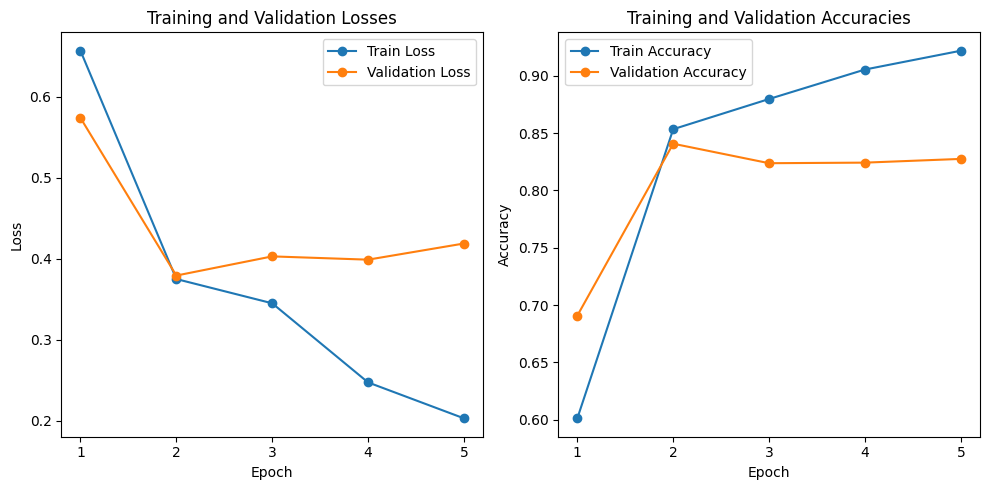

Testing: 100%|██████████| 501/501 [00:35<00:00, 14.05it/s]

Test Accuracy: 0.8237827715355805


In [191]:
ModelToRun3(len(word_to_idx_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader, val_loader, num_epochs, test_loader)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.20it/s]


Epoch 1/5, Train Loss: 0.6793566203279042, Val Loss: 0.5635839416966453, Val Acc: 0.7445054945054945


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.18it/s]


Epoch 2/5, Train Loss: 0.5169169968183553, Val Loss: 0.5177320591457836, Val Acc: 0.7824675324675324


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.21it/s]


Epoch 3/5, Train Loss: 0.38926557949876045, Val Loss: 0.4194070319165955, Val Acc: 0.8204295704295704


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.23it/s]


Epoch 4/5, Train Loss: 0.3170235346383101, Val Loss: 0.41971368133485853, Val Acc: 0.820929070929071


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.22it/s]


Epoch 5/5, Train Loss: 0.265855995233096, Val Loss: 0.40043471338270187, Val Acc: 0.8264235764235764


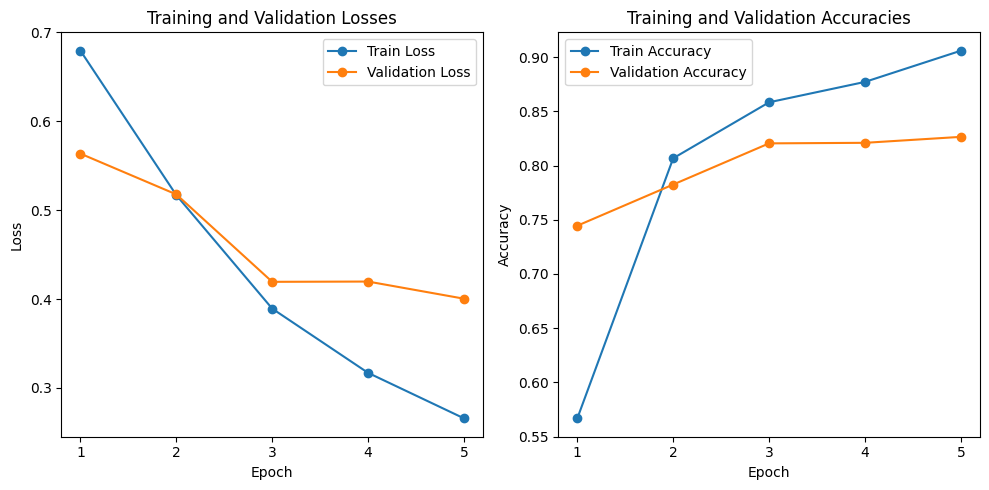

Testing: 100%|██████████| 501/501 [01:36<00:00,  5.19it/s]

Test Accuracy: 0.8302122347066168


In [192]:
ModelToRun3(len(word_to_idx_stem_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader_stem, val_loader_stem, num_epochs, test_loader_stem)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.72it/s]


Epoch 1/5, Train Loss: 0.6809428435994374, Val Loss: 0.6776589532117625, Val Acc: 0.6261238761238761


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.73it/s]


Epoch 2/5, Train Loss: 0.6038744267259026, Val Loss: 0.4872453299971608, Val Acc: 0.794955044955045


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.77it/s]


Epoch 3/5, Train Loss: 0.39586560637959456, Val Loss: 0.4680335126913987, Val Acc: 0.7714785214785215


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.57it/s]


Epoch 4/5, Train Loss: 0.30024914854210977, Val Loss: 0.4167122775381738, Val Acc: 0.8221778221778222


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.70it/s]


Epoch 5/5, Train Loss: 0.2368326942118031, Val Loss: 0.8873569576533048, Val Acc: 0.810939060939061


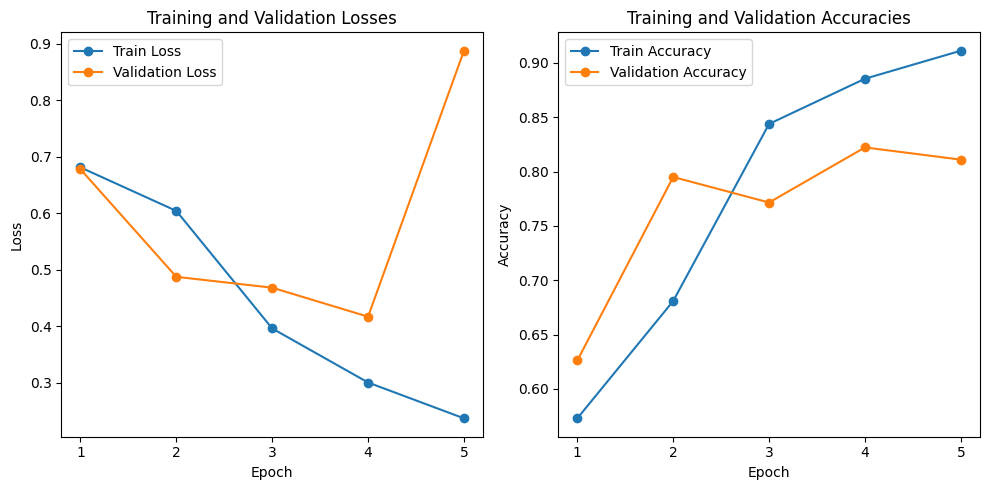

Testing: 100%|██████████| 501/501 [00:47<00:00, 10.58it/s]

Test Accuracy: 0.8036828963795256


In [193]:
ModelToRun3(len(word_to_idx_lemm_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader_lemm, val_loader_lemm, num_epochs, test_loader_lemm)

#### 1.4 Incorporate stemming/lemmatization when doing text preprocessing using the NLTK library. What changes do you observe in accuracy ?

#### 1.5 In the Model class, experiment with only picking the last output and mean of all outputs in the RNN layer. What changes do you observe ?

### 2. Hyperparameter Tuning
#### 2.1 Starting with the best configurations based on the above experiments, experiment with 5 different hyperparameter configurations. You can change the size of embedding layer, hidden state, batch in the dataloader.


#### 2.2 Evaluate the performance of the configurations on the validation sets using metrics like accuracy and loss. Analyze the results.

In [195]:
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)  # Move model to GPU if available

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.float().to(device)  # Move inputs and labels to GPU
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * inputs.size(0)

#         train_loss /= len(train_loader.dataset)

#         print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}')

        
# def evaluate_model(model, val_loader, criterion):
#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs = inputs.to(device)  # Move inputs to GPU
#             labels = labels.float().to(device)  # Move labels to GPU
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item() * inputs.size(0)
#             # _, predicted = torch.max(outputs, 1)\
#             predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid activation and round to get predictions
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     val_loss /= len(val_loader.dataset)
#     val_accuracy = correct / total

#     return val_accuracy


# # Testing function
# def test_model(model, test_loader, device):
#     model.to(device)
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.float().to(device)  # Move data to GPU
#             outputs = model(inputs)
#             # _, predicted = torch.max(outputs, 1)
#             predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid activation and round to get predictions
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     test_accuracy = correct / total
#     print(f'Test Accuracy: {test_accuracy}')

In [196]:
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
#     model.to(device)
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.float().to(device)  # Convert labels to float
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * inputs.size(0)

#         train_loss /= len(train_loader.dataset)

#         # Validation
#         model.eval()
#         val_loss = 0.0
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.float().to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item() * inputs.size(0)

#                 # Apply sigmoid activation and round to get predictions
#                 predicted = torch.round(torch.sigmoid(outputs))

#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         val_loss /= len(val_loader.dataset)
#         val_accuracy = correct / total

#         print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_accuracy}')
        
        
        
# # Testing function
# def test_model(model, test_loader, device):
#     model.to(device)
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.float().to(device)  # Move data to GPU
#             outputs = model(inputs)
#             # _, predicted = torch.max(outputs, 1)
#             predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid activation and round to get predictions
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     test_accuracy = correct / total
#     print(f'Test Accuracy: {test_accuracy}')

In [197]:
# # Training function
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
#     model.to(device)
    
#     train_losses = []
#     val_losses = []
#     train_accuracies = []
#     val_accuracies = []
    
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         correct_train = 0
#         total_train = 0
        
#         progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
#         for inputs, labels in progress_bar_train:
#             inputs, labels = inputs.to(device), labels.float().to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * inputs.size(0)
# #             progress_bar_train.set_postfix({'train_loss': train_loss / len(train_loader.dataset)})
            
#             # Calculate training accuracy
#             predicted_train = torch.round(torch.sigmoid(outputs))
#             total_train += labels.size(0)
#             correct_train += (predicted_train == labels).sum().item()
        
#         train_loss /= len(train_loader.dataset)
#         train_losses.append(train_loss)
#         train_accuracy = correct_train / total_train
#         train_accuracies.append(train_accuracy)

#         # Validation
#         model.eval()
#         val_loss = 0.0
#         correct_val = 0
#         total_val = 0
        
#         with torch.no_grad():
#             progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
#             for inputs, labels in progress_bar_val:
#                 inputs, labels = inputs.to(device), labels.float().to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item() * inputs.size(0)

#                 predicted_val = torch.round(torch.sigmoid(outputs))

#                 total_val += labels.size(0)
#                 correct_val += (predicted_val == labels).sum().item()
        
#         val_loss /= len(val_loader.dataset)
#         val_losses.append(val_loss)
#         val_accuracy = correct_val / total_val
#         val_accuracies.append(val_accuracy)

#         print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_accuracy}')

#     # Plotting the graphs for each epoch
#     plt.figure(figsize=(10, 5))
#     plt.plot(train_losses, marker='o', label='Train Loss')
#     plt.plot(val_losses, marker='o', label='Val Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Training and Validation Loss')
#     plt.legend()plt.xticks(range(1, num_epochs + 1))
#     plt.show()

#     plt.figure(figsize=(10, 5))
#     plt.plot(train_accuracies, marker='o', label='Train Accuracy')
#     plt.plot(val_accuracies, marker='o', label='Val Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Training and Validation Accuracy')
#     plt.legend()plt.xticks(range(1, num_epochs + 1))
#     plt.show()

    

# # Testing function
# def test_model(model, test_loader, device):
#     model.to(device)
#     model.eval()
# #     test_accuracies = []
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         progress_bar_test = tqdm(test_loader, desc='Testing')
#         for inputs, labels in progress_bar_test:
#             inputs, labels = inputs.to(device), labels.float().to(device)
#             outputs = model(inputs)
#             predicted = torch.round(torch.sigmoid(outputs))
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
# #             test_accuracies.append(correct / total)
    
# #     # Plotting the testing accuracy graph
# #     plt.figure(figsize=(10, 5))
# #     plt.plot(test_accuracies, marker='o', label='Test Accuracy')
# #     plt.xlabel('Epoch')
# #     plt.ylabel('Accuracy')
# #     plt.title('Testing Accuracy')
# #     plt.legend()plt.xticks(range(1, num_epochs + 1))
# #     plt.show()

# #     return test_accuracies
#     test_accuracy = correct / total  
#     print(f'Test Accuracy: {test_accuracy}')


In [198]:
# import itertools

# # Define ranges for hyperparameters
# input_size = len(word_to_idx_train)
# embedding_sizes = [100, 200, 300]
# hidden_sizes = [128, 256, 512]
# batch_sizes = [32, 64, 128]
# num_layers = [1] #[1, 2]
# learning_rates = [0.005] # [0.001, 0.005]

# # Define other hyperparameters
# output_size = 2
# num_epochs = 5

# best_accuracy = 0.0
# best_hyperparameters = {}
# best_validation_loss = float('inf')
# best_model_state = None


# # Check if GPU is available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Iterate over all combinations of hyperparameters
# for embedding_size, hidden_size, batch_size, num_layers, learning_rate in itertools.product(embedding_sizes, hidden_sizes, batch_sizes, num_layers, learning_rates):
#     # Initialize model, criterion, and optimizer
#     model = RNN(input_size, embedding_size, hidden_size, num_layers, output_size).to(device)  # Move model to GPU
# #     criterion = nn.CrossEntropyLoss()
#     criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits
    
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
#     print(f"Embedding Size: {embedding_size}, Hidden Size: {hidden_size}, Batch Size: {batch_size}, Num Layers: {num_layers}, Learning Rate: {learning_rate}")
    
#     # Create train and validation data loaders with current batch size
#     train_dataset, train_loader = create_dataset_and_loader(train_data, word_to_idx_train, batch_size, shuffle=True)
#     val_dataset, val_loader = create_dataset_and_loader(val_data, word_to_idx_train, batch_size, shuffle=False)
    
#     # Train the model
#     train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

#     # Evaluate the model on the validation set
#     val_accuracy = evaluate_model(model, val_loader, criterion)

#     # Print results
#     print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
#     print()
#     # Update best hyperparameters if current configuration performs better
#     if val_accuracy > best_accuracy:
#         best_accuracy = val_accuracy
#         best_hyperparameters = {
#             'embedding_size': embedding_size,
#             'hidden_size': hidden_size,
#             'batch_size': batch_size,
#             'num_layers': num_layers,
#             'learning_rate': learning_rate
#         }
#         # Save the state of the best model
#         best_model_state = model.state_dict()

#     # Update best validation loss if current configuration has lower validation loss
#     if val_loss < best_validation_loss:
#         best_validation_loss = val_loss



In [199]:
# import itertools

# # Define ranges for hyperparameters
# embedding_sizes = [200, 300]
# hidden_sizes = [128, 256]
# batch_sizes = [32, 64]
# num_layers = [1, 2]
# learning_rates = [0.001, 0.005]

# # Define other hyperparameters
# output_size = 2
# num_epochs = 5

# best_accuracy = 0.0
# best_hyperparameters = {}
# best_validation_loss = float('inf')
# best_model_state = None
# best_model_path = 'best_model.pth'  # Path to save the best model

# # Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Iterate over all combinations of hyperparameters
# for embedding_size, hidden_size, batch_size, num_layers, learning_rate in itertools.product(embedding_sizes, hidden_sizes, batch_sizes, num_layers, learning_rates):
#     # Initialize model, criterion, and optimizer
#     model = RNN(input_size, embedding_size, hidden_size, num_layers, output_size).to(device)  # Move model to GPU
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     # Create train and validation data loaders with current batch size
#     train_dataset, train_loader = create_dataset_and_loader(train_data, word_to_idx_train, batch_size, shuffle=True)
#     val_dataset, val_loader = create_dataset_and_loader(val_data, word_to_idx_train, batch_size, shuffle=False)

#     # Train the model
#     train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

#     # Evaluate the model on the validation set
#     val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

#     # Print results
#     print(f"Embedding Size: {embedding_size}, Hidden Size: {hidden_size}, Batch Size: {batch_size}, Num Layers: {num_layers}, Learning Rate: {learning_rate}")
#     print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

#     # Update best hyperparameters if current configuration performs better
#     if val_accuracy > best_accuracy:
#         best_accuracy = val_accuracy
#         best_hyperparameters = {
#             'embedding_size': embedding_size,
#             'hidden_size': hidden_size,
#             'batch_size': batch_size,
#             'num_layers': num_layers,
#             'learning_rate': learning_rate
#         }
#         # Save the state of the best model
#         best_model_state = model.state_dict()

#     # Update best validation loss if current configuration has lower validation loss
#     if val_loss < best_validation_loss:
#         best_validation_loss = val_loss

# # Save the best model's state dictionary to a file
# if best_model_state:
#     torch.save(best_model_state, best_model_path)

# print("Best Hyperparameters:", best_hyperparameters)
# print("Best Validation Loss:", best_validation_loss)

# # Load the best model for testing
# best_model = RNN(input_size, best_hyperparameters['embedding_size'], best_hyperparameters['hidden_size'], best_hyperparameters['num_layers'], output_size).to(device)
# best_model.load_state_dict(torch.load(best_model_path))

In [200]:
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)  # Move model to GPU if available

#     best_accuracy = 0.0
#     best_hyperparameters = {}
#     best_validation_loss = float('inf')
#     best_model_state = None

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.float().to(device)  # Move inputs and labels to GPU
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * inputs.size(0)

#         train_loss /= len(train_loader.dataset)

#         print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}')

#         # Evaluate the model on the validation set
#         model.eval()
#         val_loss = 0.0
#         correct = 0
#         total = 0

#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs = inputs.to(device)  # Move inputs to GPU
#                 labels = labels.float().to(device)  # Move labels to GPU
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item() * inputs.size(0)
#                 predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid activation and round to get predictions
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         val_loss /= len(val_loader.dataset)
#         val_accuracy = correct / total

#         # Print results
#         print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
#         print()

#         # Update best hyperparameters if current configuration performs better
#         if val_accuracy > best_accuracy:
#             best_accuracy = val_accuracy
#             best_hyperparameters = {
#                 'embedding_size': embedding_size,
#                 'hidden_size': hidden_size,
#                 'batch_size': batch_size,
#                 'num_layers': num_layers,
#                 'learning_rate': learning_rate
#             }
#             # Save the state of the best model
#             best_model_state = model.state_dict()

#         # Update best validation loss if current configuration has lower validation loss
#         if val_loss < best_validation_loss:
#             best_validation_loss = val_loss

#     return best_accuracy, best_hyperparameters, best_model_state


In [95]:
class RNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Output size is 1 for binary classification

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output_mean = torch.mean(output, dim=1)
        output = self.fc(output_mean)
        return output.squeeze(1)  # Ensure output shape is [batch_size]


In [96]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU if available

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_accuracy = 0.0
    best_hyperparameters = {}
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Training)')

        for inputs, labels in progress_bar_train:
            inputs, labels = inputs.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

#             progress_bar_train.set_postfix({'Train Loss': train_loss / len(train_loader.dataset)})

        train_loss /= len(train_loader.dataset)
        train_accuracy = correct_train / total_train

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)')

        with torch.no_grad():
            for inputs, labels in progress_bar_val:
                inputs = inputs.to(device)
                labels = labels.float().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                predicted = torch.round(torch.sigmoid(outputs))
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

#                 progress_bar_val.set_postfix({'Validation Loss': val_loss / len(val_loader.dataset)})

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct_val / total_val

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print results
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")
#         print()

        # Update best hyperparameters if current configuration performs better
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_hyperparameters = {
                'embedding_size': embedding_size,
                'hidden_size': hidden_size,
                'batch_size': batch_size,
                'num_layers': num_layer,
                'learning_rate': learning_rate
            }
            # Save the state of the best model
            best_model_state = model.state_dict()

    # Plot the losses and accuracies
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.xticks(range(1, num_epochs + 1))

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.xticks(range(1, num_epochs + 1))

    plt.tight_layout()
    plt.show()

    return best_accuracy, best_hyperparameters, best_model_state


In [97]:
import itertools

best_accuracy = 0.0
best_hyperparameters = {}
best_validation_loss = float('inf')
best_model_state = None

# Define other hyperparameters
output_size = 1
num_epochs = 5
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



Embedding Size: 100, Hidden Size: 128, Batch Size: 32, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.64it/s]


Epoch 1/5, Train Loss: 0.5510251008161379, Validation Loss: 0.40383364654682974, Train Accuracy: 0.718238930993219, Validation Accuracy: 0.8189310689310689



Epoch 2/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.27it/s]


Epoch 2/5, Train Loss: 0.34299209899383093, Validation Loss: 0.38957901934643724, Train Accuracy: 0.8703131232548863, Validation Accuracy: 0.846903096903097



Epoch 3/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.74it/s]


Epoch 3/5, Train Loss: 0.3215879803106611, Validation Loss: 0.40705984461676703, Train Accuracy: 0.8886118867171918, Validation Accuracy: 0.8266733266733267



Epoch 4/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.75it/s]


Epoch 4/5, Train Loss: 0.2077450128662239, Validation Loss: 0.4097269864885004, Train Accuracy: 0.9298464299960112, Validation Accuracy: 0.8394105894105894



Epoch 5/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.48it/s]


Epoch 5/5, Train Loss: 0.10595359300320063, Validation Loss: 0.47632035181358023, Train Accuracy: 0.9643498205025928, Validation Accuracy: 0.8371628371628371



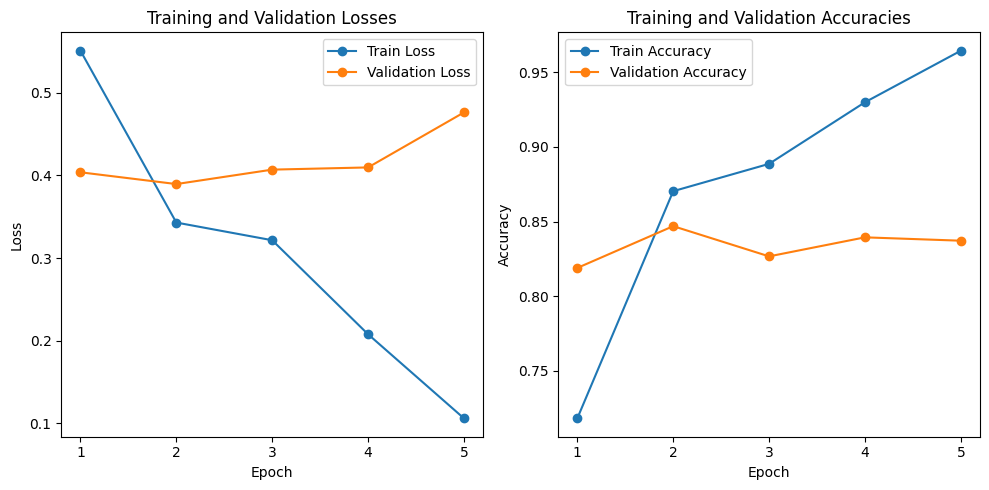

Best Validation Accuracy: 0.846903096903097

Embedding Size: 100, Hidden Size: 128, Batch Size: 64, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.41it/s]


Epoch 1/5, Train Loss: 0.6943061901936267, Validation Loss: 0.6094378916533677, Train Accuracy: 0.5774830474670921, Validation Accuracy: 0.6923076923076923



Epoch 2/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.32it/s]


Epoch 2/5, Train Loss: 0.5550138822080226, Validation Loss: 0.4189281675008151, Train Accuracy: 0.7174411647387315, Validation Accuracy: 0.8214285714285714



Epoch 3/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.37it/s]


Epoch 3/5, Train Loss: 0.330684702330773, Validation Loss: 0.39687199091220593, Train Accuracy: 0.8765955325089748, Validation Accuracy: 0.8259240759240759



Epoch 4/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.33it/s]


Epoch 4/5, Train Loss: 0.21190983561058183, Validation Loss: 0.39682123764649735, Train Accuracy: 0.9233645791783007, Validation Accuracy: 0.8379120879120879



Epoch 5/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.37it/s]


Epoch 5/5, Train Loss: 0.1377501892565635, Validation Loss: 0.4398507315378923, Train Accuracy: 0.950538492221779, Validation Accuracy: 0.8266733266733267



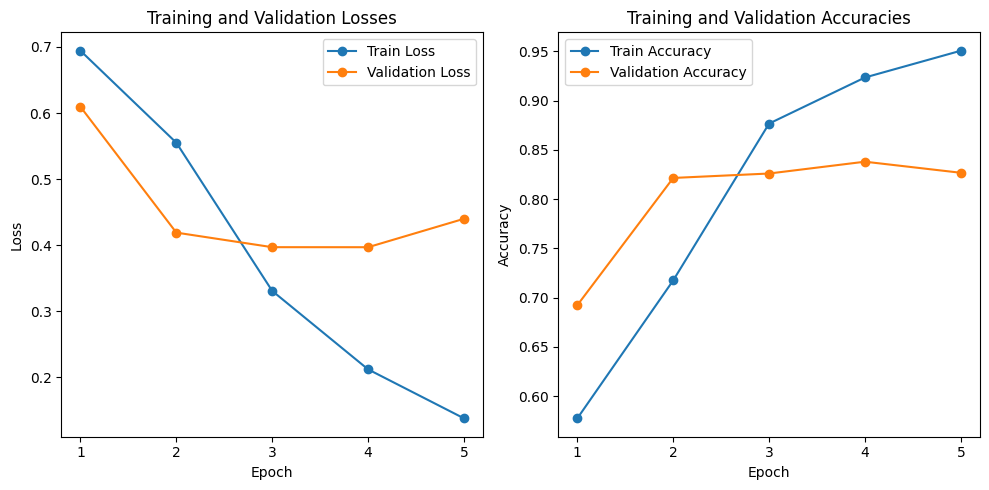

Best Validation Accuracy: 0.8379120879120879

Embedding Size: 100, Hidden Size: 128, Batch Size: 128, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 1/5, Train Loss: 0.6827824448844946, Validation Loss: 0.6645165214409957, Train Accuracy: 0.5823195053849222, Validation Accuracy: 0.5741758241758241



Epoch 2/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 2/5, Train Loss: 0.5803964393139837, Validation Loss: 0.5926204840620081, Train Accuracy: 0.7086657359393698, Validation Accuracy: 0.6620879120879121



Epoch 3/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 3/5, Train Loss: 0.35971977995314064, Validation Loss: 0.4522518696603956, Train Accuracy: 0.8562026326286398, Validation Accuracy: 0.8221778221778222



Epoch 4/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 4/5, Train Loss: 0.24528317849475356, Validation Loss: 0.43690550619072016, Train Accuracy: 0.9097028320702034, Validation Accuracy: 0.8286713286713286



Epoch 5/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 5/5, Train Loss: 0.15719497832088866, Validation Loss: 0.3879068695998692, Train Accuracy: 0.944305943358596, Validation Accuracy: 0.8389110889110889



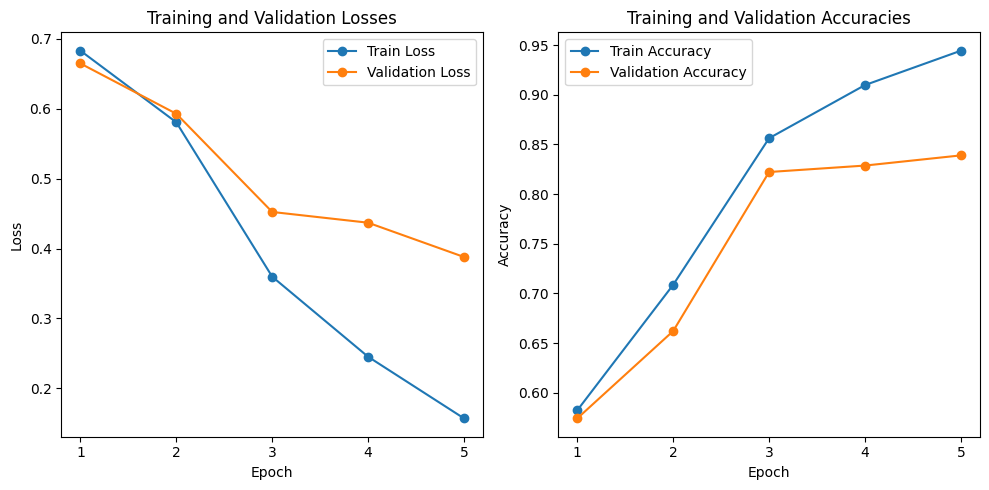

Best Validation Accuracy: 0.8389110889110889

Embedding Size: 100, Hidden Size: 256, Batch Size: 32, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.14it/s]


Epoch 1/5, Train Loss: 0.687622132175797, Validation Loss: 0.6359296438696382, Train Accuracy: 0.5330574391703231, Validation Accuracy: 0.5666833166833167



Epoch 2/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.16it/s]


Epoch 2/5, Train Loss: 0.5565948235261093, Validation Loss: 0.7092868339169871, Train Accuracy: 0.723923015556442, Validation Accuracy: 0.5494505494505495



Epoch 3/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.33it/s]


Epoch 3/5, Train Loss: 0.5367781727210336, Validation Loss: 0.5119659800331791, Train Accuracy: 0.7941264459513363, Validation Accuracy: 0.7804695304695305



Epoch 4/5 (Validation): 100%|██████████| 126/126 [00:09<00:00, 13.75it/s]


Epoch 4/5, Train Loss: 0.3755007138231336, Validation Loss: 0.42100472294248187, Train Accuracy: 0.8627842042281612, Validation Accuracy: 0.8214285714285714



Epoch 5/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.00it/s]


Epoch 5/5, Train Loss: 0.2557445821245686, Validation Loss: 0.39944200889094844, Train Accuracy: 0.9014260071798963, Validation Accuracy: 0.8376623376623377



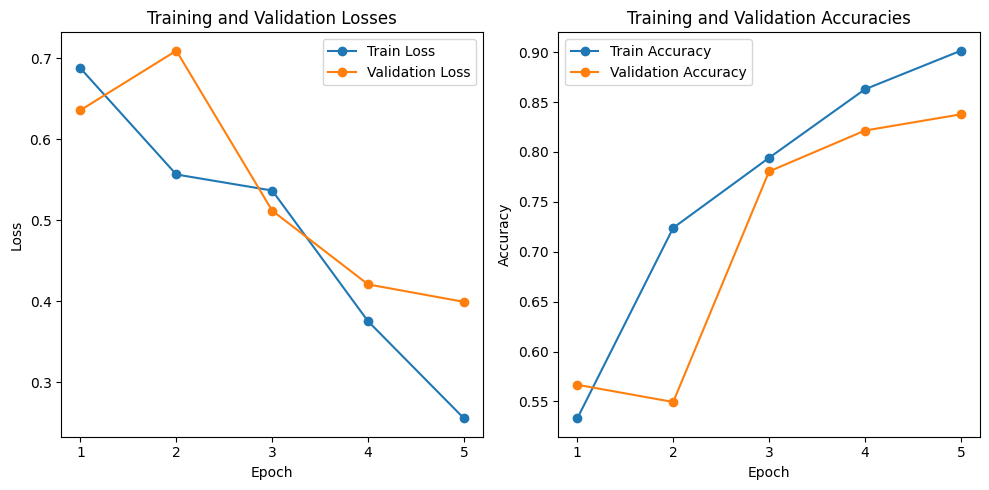

Best Validation Accuracy: 0.8376623376623377

Embedding Size: 100, Hidden Size: 256, Batch Size: 64, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.12it/s]


Epoch 1/5, Train Loss: 0.6694841818073426, Validation Loss: 0.6092910389085631, Train Accuracy: 0.6035600319106502, Validation Accuracy: 0.774975024975025



Epoch 2/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.02it/s]


Epoch 2/5, Train Loss: 0.5890693157186154, Validation Loss: 0.5535811965877597, Train Accuracy: 0.7332469086557638, Validation Accuracy: 0.7827172827172827



Epoch 3/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.06it/s]


Epoch 3/5, Train Loss: 0.378093546089253, Validation Loss: 0.44049039542615476, Train Accuracy: 0.8653270841643399, Validation Accuracy: 0.8051948051948052



Epoch 4/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.05it/s]


Epoch 4/5, Train Loss: 0.40047588419001273, Validation Loss: 0.4370261600146165, Train Accuracy: 0.8560530514559234, Validation Accuracy: 0.8136863136863137



Epoch 5/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.02it/s]


Epoch 5/5, Train Loss: 0.339879889720267, Validation Loss: 0.5937751989502769, Train Accuracy: 0.8900079776625449, Validation Accuracy: 0.6795704295704296



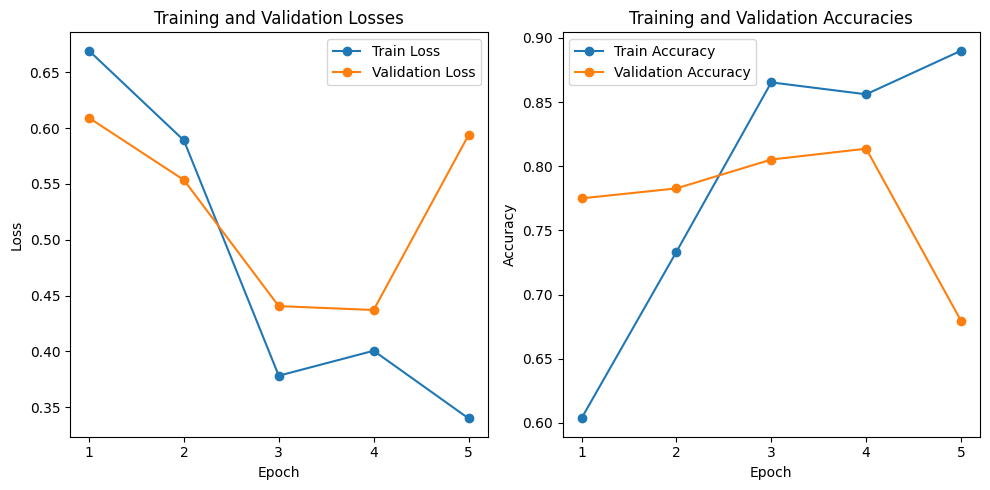

Best Validation Accuracy: 0.8136863136863137

Embedding Size: 100, Hidden Size: 256, Batch Size: 128, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


Epoch 1/5, Train Loss: 0.6971361101933766, Validation Loss: 0.6925658296633672, Train Accuracy: 0.5040386916633426, Validation Accuracy: 0.5157342657342657



Epoch 2/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


Epoch 2/5, Train Loss: 0.6926133825477491, Validation Loss: 0.6892596280181801, Train Accuracy: 0.5178998803350618, Validation Accuracy: 0.6028971028971029



Epoch 3/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


Epoch 3/5, Train Loss: 0.5314274227828394, Validation Loss: 0.4334203555926934, Train Accuracy: 0.7449142401276426, Validation Accuracy: 0.8341658341658341



Epoch 4/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


Epoch 4/5, Train Loss: 0.25579514672759046, Validation Loss: 0.3730116868531192, Train Accuracy: 0.9096031112883926, Validation Accuracy: 0.8436563436563437



Epoch 5/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


Epoch 5/5, Train Loss: 0.42780497057960004, Validation Loss: 0.6924021641810338, Train Accuracy: 0.8535600319106502, Validation Accuracy: 0.510989010989011



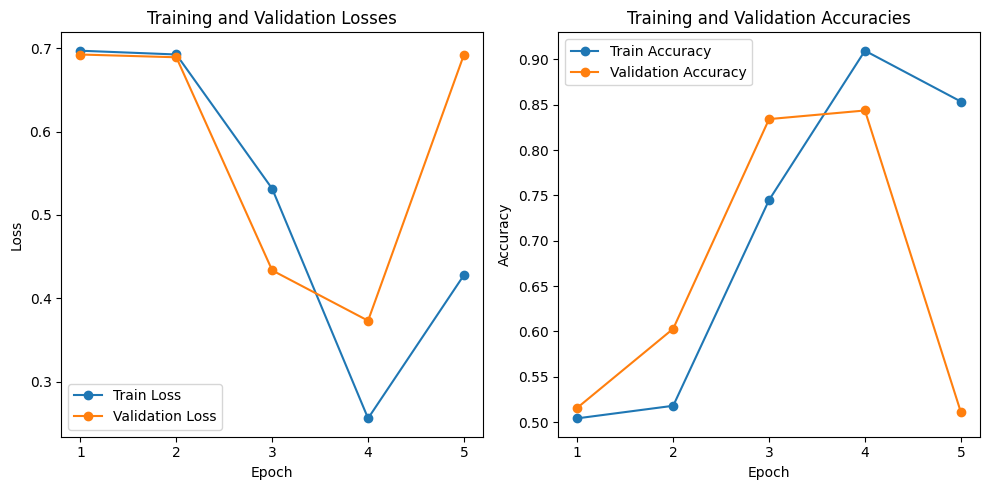

Best Validation Accuracy: 0.8436563436563437

Embedding Size: 100, Hidden Size: 512, Batch Size: 32, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 126/126 [00:10<00:00, 12.48it/s]


Epoch 1/5, Train Loss: 0.6885141116668373, Validation Loss: 0.6475748410829892, Train Accuracy: 0.5460710011966494, Validation Accuracy: 0.6251248751248751



Epoch 2/5 (Validation): 100%|██████████| 126/126 [00:10<00:00, 12.45it/s]


Epoch 2/5, Train Loss: 0.4661861420343442, Validation Loss: 0.4257327197314976, Train Accuracy: 0.8170123653769445, Validation Accuracy: 0.8454045954045954



Epoch 3/5 (Validation): 100%|██████████| 126/126 [00:10<00:00, 12.57it/s]


Epoch 3/5, Train Loss: 0.3892250776314669, Validation Loss: 0.49259015059584266, Train Accuracy: 0.8516653370562425, Validation Accuracy: 0.7542457542457542



Epoch 4/5 (Validation): 100%|██████████| 126/126 [00:10<00:00, 12.50it/s]


Epoch 4/5, Train Loss: 0.2596800328846419, Validation Loss: 0.45108134882314344, Train Accuracy: 0.9071599521340248, Validation Accuracy: 0.8006993006993007



Epoch 5/5 (Validation): 100%|██████████| 126/126 [00:10<00:00, 12.53it/s]


Epoch 5/5, Train Loss: 0.23575401148641068, Validation Loss: 0.36130577355593474, Train Accuracy: 0.9125947347427203, Validation Accuracy: 0.8431568431568431



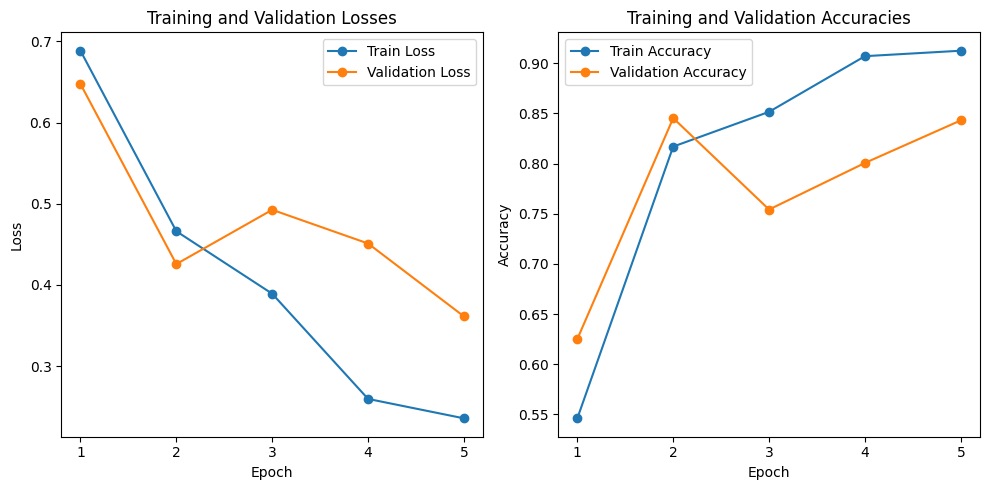

Best Validation Accuracy: 0.8454045954045954

Embedding Size: 100, Hidden Size: 512, Batch Size: 64, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.49it/s]


Epoch 1/5, Train Loss: 0.6957530445866154, Validation Loss: 0.6914980527642486, Train Accuracy: 0.5154567211806941, Validation Accuracy: 0.5437062937062938



Epoch 2/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.58it/s]


Epoch 2/5, Train Loss: 0.6436813651302872, Validation Loss: 0.5831586415474708, Train Accuracy: 0.661796968488233, Validation Accuracy: 0.7714785214785215



Epoch 3/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.53it/s]


Epoch 3/5, Train Loss: 0.5968759305742475, Validation Loss: 0.6915616368080353, Train Accuracy: 0.7269146390107698, Validation Accuracy: 0.501998001998002



Epoch 4/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.51it/s]


Epoch 4/5, Train Loss: 0.6838382427132268, Validation Loss: 0.6804366757224252, Train Accuracy: 0.5881033107299561, Validation Accuracy: 0.5114885114885115



Epoch 5/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.54it/s]


Epoch 5/5, Train Loss: 0.5622519217357248, Validation Loss: 0.42697279552717904, Train Accuracy: 0.7566812923813323, Validation Accuracy: 0.8321678321678322



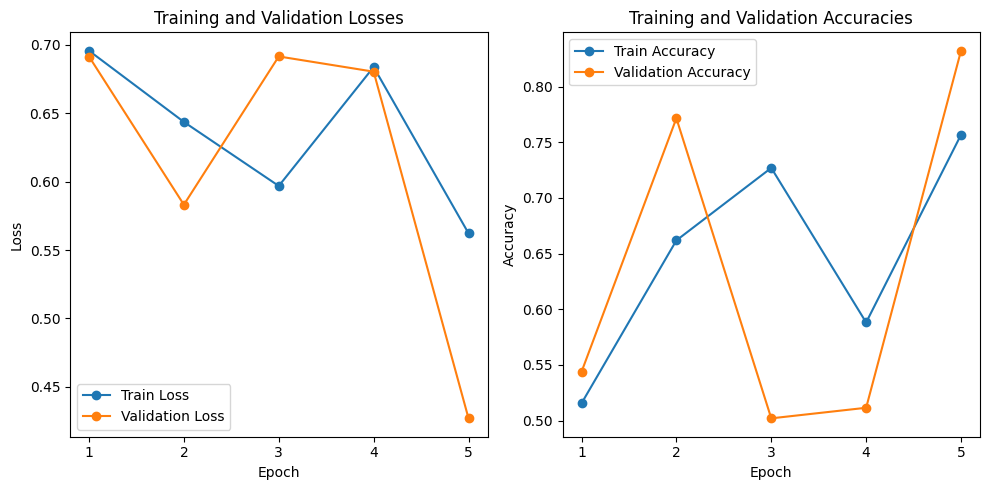

Best Validation Accuracy: 0.8321678321678322

Embedding Size: 100, Hidden Size: 512, Batch Size: 128, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch 1/5, Train Loss: 0.7014029529829828, Validation Loss: 0.6930656568868296, Train Accuracy: 0.5045372955723972, Validation Accuracy: 0.5079920079920079



Epoch 2/5 (Validation): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


Epoch 2/5, Train Loss: 0.6929718334455152, Validation Loss: 0.6931258535885311, Train Accuracy: 0.5095233346629437, Validation Accuracy: 0.5094905094905094



Epoch 3/5 (Validation): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


Epoch 3/5, Train Loss: 0.6918495463145697, Validation Loss: 0.689768087137472, Train Accuracy: 0.5142102114080574, Validation Accuracy: 0.5244755244755245



Epoch 4/5 (Validation): 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch 4/5, Train Loss: 0.6505933603918975, Validation Loss: 0.6214542608041982, Train Accuracy: 0.6831870761866773, Validation Accuracy: 0.7292707292707292



Epoch 5/5 (Validation): 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]


Epoch 5/5, Train Loss: 0.6057417399387793, Validation Loss: 0.6199827545529956, Train Accuracy: 0.7580275229357798, Validation Accuracy: 0.775974025974026



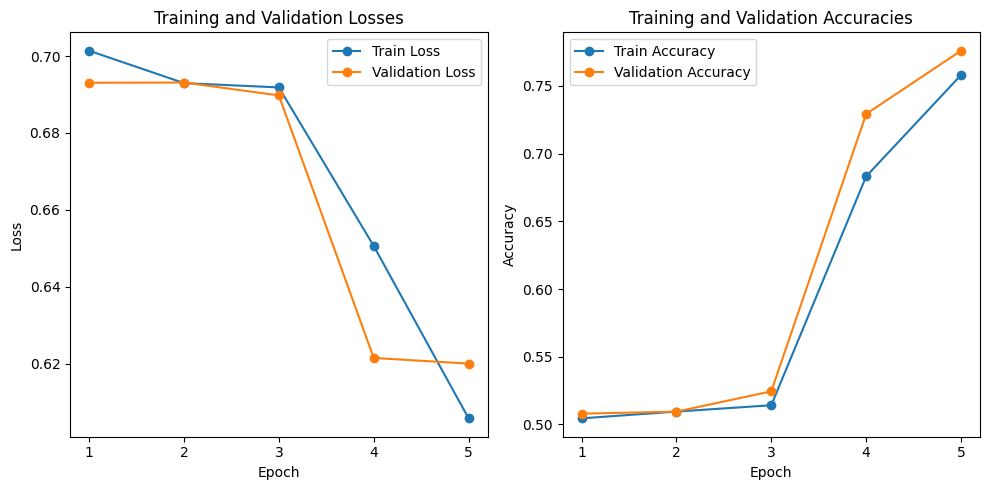

Best Validation Accuracy: 0.775974025974026

Best Hyperparameters: {'embedding_size': 100, 'hidden_size': 128, 'batch_size': 32, 'num_layers': [1], 'learning_rate': 0.005}
Best Validation Accuracy: 0.846903096903097


In [98]:
# Define ranges for hyperparameters
# input_size = len(word_to_idx_train)
embedding_sizes = [100]
hidden_sizes = [128, 256, 512]
batch_sizes = [32, 64, 128]
num_layers = [1] #[1, 2]
learning_rates = [0.005] #[0.001, 0.005]


# Iterate over all combinations of hyperparameters
for embedding_size, hidden_size, batch_size, num_layer, learning_rate in itertools.product(embedding_sizes, hidden_sizes, batch_sizes, num_layers, learning_rates):
    # Initialize model, criterion, and optimizer
    model = RNN(len(word_to_idx_train), embedding_size, hidden_size, num_layer, output_size).to(device)  # Move model to GPU
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    print(f"Embedding Size: {embedding_size}, Hidden Size: {hidden_size}, Batch Size: {batch_size}, Num Layers: {num_layer}, Learning Rate: {learning_rate}")
    
    # Create train and validation data loaders with current batch size
    train_dataset, train_loader = create_dataset_and_loader(train_data, word_to_idx_train, batch_size, shuffle=True)
    val_dataset, val_loader = create_dataset_and_loader(val_data, word_to_idx_train, batch_size, shuffle=False)
    
    # Train the model
    accuracy, hyperparameters, model_state = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    
    # Print results
    print(f"Best Validation Accuracy: {accuracy}")
    print()
    
    # Update best hyperparameters if current configuration performs better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparameters = hyperparameters
        best_model_state = model_state

print("Best Hyperparameters:", best_hyperparameters)
print("Best Validation Accuracy:", best_accuracy)


Embedding Size: 200, Hidden Size: 128, Batch Size: 32, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.28it/s]


Epoch 1/5, Train Loss: 0.5722135022716499, Validation Loss: 0.5884073428459815, Train Accuracy: 0.7102114080574392, Validation Accuracy: 0.6885614385614386



Epoch 2/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.39it/s]


Epoch 2/5, Train Loss: 0.3798865428722661, Validation Loss: 0.37815223073030446, Train Accuracy: 0.8434383725568408, Validation Accuracy: 0.8371628371628371



Epoch 3/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.21it/s]


Epoch 3/5, Train Loss: 0.20631369525187035, Validation Loss: 0.37057650398898434, Train Accuracy: 0.9225668129238134, Validation Accuracy: 0.8474025974025974



Epoch 4/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.27it/s]


Epoch 4/5, Train Loss: 0.15628476699759963, Validation Loss: 0.4069933250591114, Train Accuracy: 0.9472975668129238, Validation Accuracy: 0.8391608391608392



Epoch 5/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.29it/s]


Epoch 5/5, Train Loss: 0.1092683084377455, Validation Loss: 0.40333701972361213, Train Accuracy: 0.9616074990027922, Validation Accuracy: 0.8459040959040959



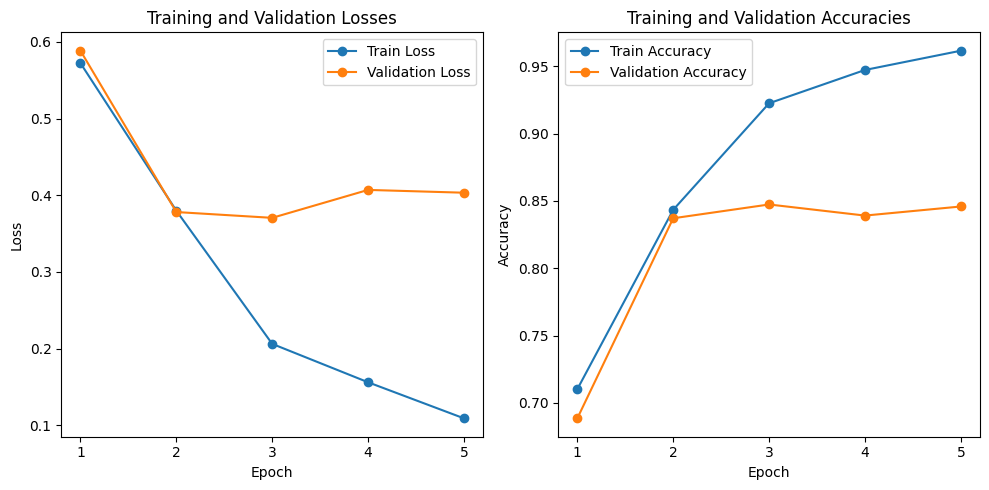

Best Validation Accuracy: 0.8474025974025974

Embedding Size: 200, Hidden Size: 128, Batch Size: 64, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.21it/s]


Epoch 1/5, Train Loss: 0.5770172348738573, Validation Loss: 0.43174065499158054, Train Accuracy: 0.6927602712405265, Validation Accuracy: 0.8191808191808192



Epoch 2/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.43it/s]


Epoch 2/5, Train Loss: 0.3107974014115324, Validation Loss: 0.38596848793677635, Train Accuracy: 0.8815317112086158, Validation Accuracy: 0.8371628371628371



Epoch 3/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.15it/s]


Epoch 3/5, Train Loss: 0.17754898775156439, Validation Loss: 0.3702113775463847, Train Accuracy: 0.9365277223773434, Validation Accuracy: 0.8434065934065934



Epoch 4/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.23it/s]


Epoch 4/5, Train Loss: 0.16339207406437725, Validation Loss: 0.40086683449330746, Train Accuracy: 0.9531312325488632, Validation Accuracy: 0.8404095904095904



Epoch 5/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.26it/s]


Epoch 5/5, Train Loss: 0.09216280211406634, Validation Loss: 0.47177868956452484, Train Accuracy: 0.9696848823294775, Validation Accuracy: 0.8376623376623377



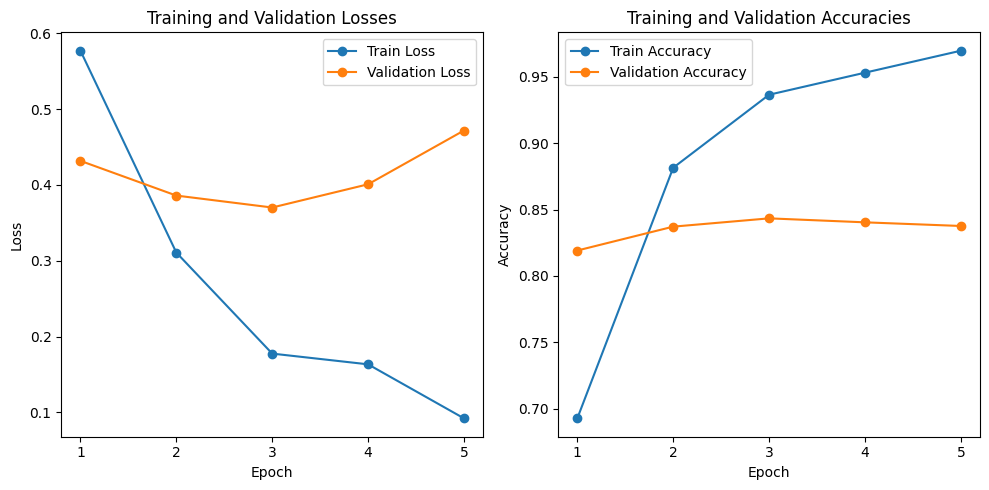

Best Validation Accuracy: 0.8434065934065934

Embedding Size: 200, Hidden Size: 128, Batch Size: 128, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


Epoch 1/5, Train Loss: 0.6701574040020325, Validation Loss: 0.6394265488192037, Train Accuracy: 0.5963302752293578, Validation Accuracy: 0.5971528471528471



Epoch 2/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 2/5, Train Loss: 0.49957274780788885, Validation Loss: 0.4127727206889447, Train Accuracy: 0.8184084563222975, Validation Accuracy: 0.830919080919081



Epoch 3/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 3/5, Train Loss: 0.26397445327763924, Validation Loss: 0.3744302374737842, Train Accuracy: 0.9027722377343438, Validation Accuracy: 0.8491508491508492



Epoch 4/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 4/5, Train Loss: 0.15020952001957005, Validation Loss: 0.39576223037102365, Train Accuracy: 0.9504886318308735, Validation Accuracy: 0.8466533466533467



Epoch 5/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 5/5, Train Loss: 0.09930457197661699, Validation Loss: 0.4339426473661379, Train Accuracy: 0.970283207020343, Validation Accuracy: 0.8456543456543456



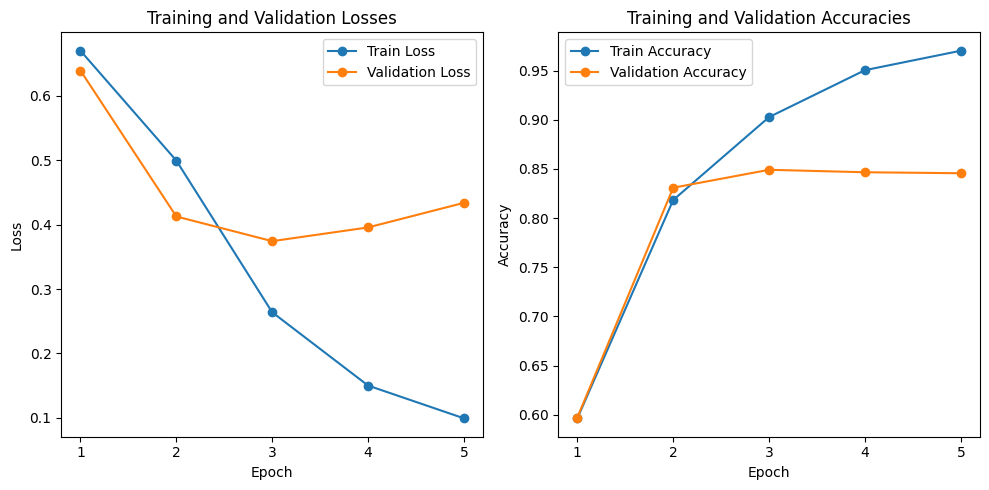

Best Validation Accuracy: 0.8491508491508492

Embedding Size: 200, Hidden Size: 256, Batch Size: 32, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 126/126 [00:09<00:00, 13.83it/s]


Epoch 1/5, Train Loss: 0.5403742543910194, Validation Loss: 0.7606499421370255, Train Accuracy: 0.7380335061826885, Validation Accuracy: 0.5182317682317682



Epoch 2/5 (Validation): 100%|██████████| 126/126 [00:09<00:00, 13.84it/s]


Epoch 2/5, Train Loss: 0.4179124315040826, Validation Loss: 0.4429870118628015, Train Accuracy: 0.8417929796569605, Validation Accuracy: 0.7987012987012987



Epoch 3/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.12it/s]


Epoch 3/5, Train Loss: 0.30625253739849617, Validation Loss: 0.414612595375244, Train Accuracy: 0.8905564419625049, Validation Accuracy: 0.8246753246753247



Epoch 4/5 (Validation): 100%|██████████| 126/126 [00:09<00:00, 13.91it/s]


Epoch 4/5, Train Loss: 0.25739148071338136, Validation Loss: 0.39540239888709505, Train Accuracy: 0.9089549262066214, Validation Accuracy: 0.8311688311688312



Epoch 5/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.06it/s]


Epoch 5/5, Train Loss: 0.24266962751621357, Validation Loss: 0.40865185734751697, Train Accuracy: 0.9115476665337057, Validation Accuracy: 0.817932067932068



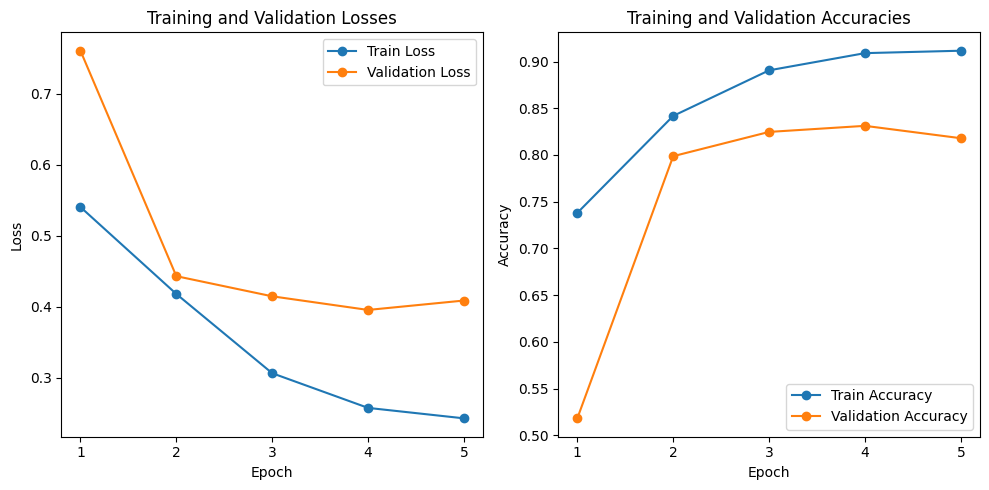

Best Validation Accuracy: 0.8311688311688312

Embedding Size: 200, Hidden Size: 256, Batch Size: 64, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.06it/s]


Epoch 1/5, Train Loss: 0.6546804891861336, Validation Loss: 0.5735842486718794, Train Accuracy: 0.6121858795372955, Validation Accuracy: 0.6608391608391608



Epoch 2/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.12it/s]


Epoch 2/5, Train Loss: 0.47205212361602417, Validation Loss: 0.48744444365982526, Train Accuracy: 0.7867471080973275, Validation Accuracy: 0.771978021978022



Epoch 3/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.75it/s]


Epoch 3/5, Train Loss: 0.30463691699490586, Validation Loss: 0.41514760452312427, Train Accuracy: 0.8746509772636617, Validation Accuracy: 0.8234265734265734



Epoch 4/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.89it/s]


Epoch 4/5, Train Loss: 0.1974841001431306, Validation Loss: 0.43511071500482856, Train Accuracy: 0.9261567610690068, Validation Accuracy: 0.8319180819180819



Epoch 5/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.17it/s]


Epoch 5/5, Train Loss: 0.15784699000540034, Validation Loss: 0.5232180707700007, Train Accuracy: 0.9421120861587555, Validation Accuracy: 0.8221778221778222



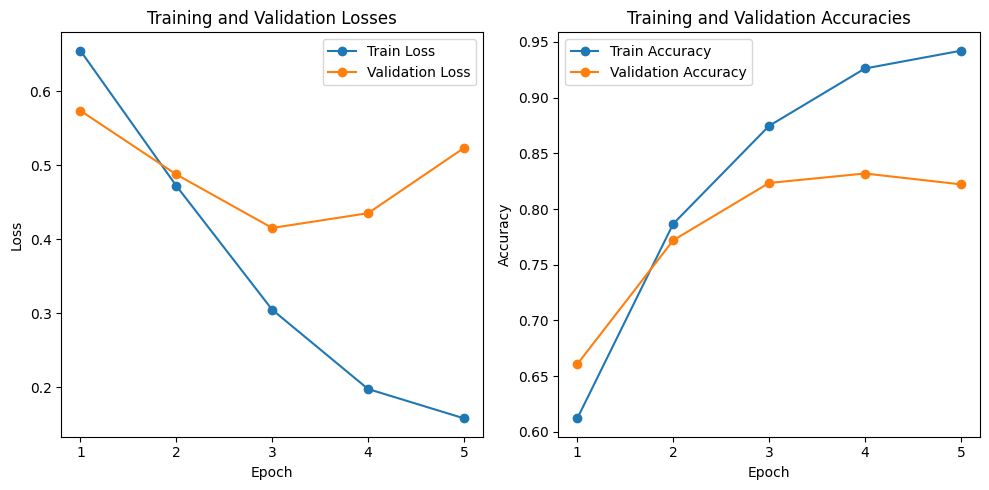

Best Validation Accuracy: 0.8319180819180819

Embedding Size: 200, Hidden Size: 256, Batch Size: 128, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 1/5, Train Loss: 0.6382611155937904, Validation Loss: 0.5184742430230597, Train Accuracy: 0.6226565616274432, Validation Accuracy: 0.7964535464535465



Epoch 2/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


Epoch 2/5, Train Loss: 0.4146812172657853, Validation Loss: 0.41993061062339304, Train Accuracy: 0.844635021938572, Validation Accuracy: 0.817932067932068



Epoch 3/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


Epoch 3/5, Train Loss: 0.37011244333166027, Validation Loss: 0.4369256436586618, Train Accuracy: 0.8801854806541684, Validation Accuracy: 0.8129370629370629



Epoch 4/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


Epoch 4/5, Train Loss: 0.27723689387412387, Validation Loss: 0.5102766670070804, Train Accuracy: 0.9108994814519346, Validation Accuracy: 0.7972027972027972



Epoch 5/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


Epoch 5/5, Train Loss: 0.3468530302890326, Validation Loss: 0.47925604497278845, Train Accuracy: 0.876495811727164, Validation Accuracy: 0.7852147852147852



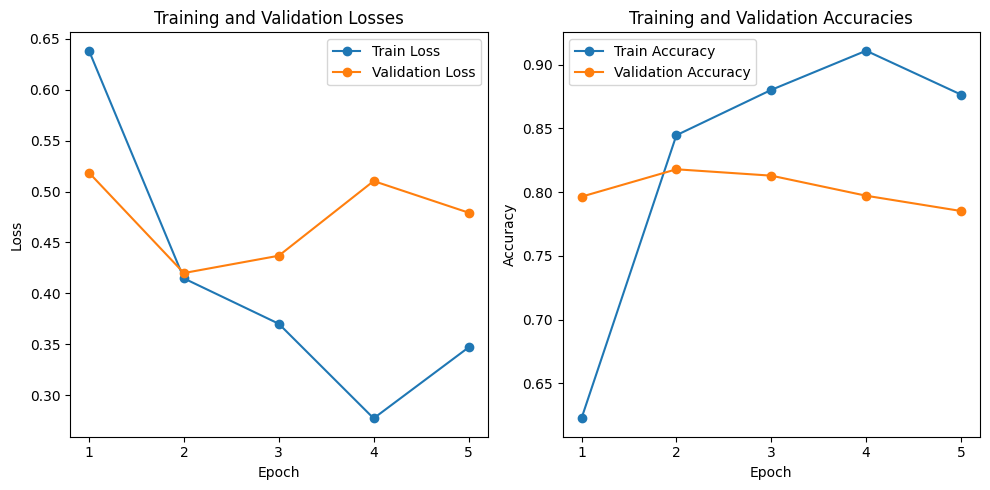

Best Validation Accuracy: 0.817932067932068

Embedding Size: 200, Hidden Size: 512, Batch Size: 32, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 126/126 [00:09<00:00, 12.64it/s]


Epoch 1/5, Train Loss: 0.689095840660471, Validation Loss: 0.6772893755943268, Train Accuracy: 0.5426306342241723, Validation Accuracy: 0.5564435564435565



Epoch 2/5 (Validation): 100%|██████████| 126/126 [00:09<00:00, 12.66it/s]


Epoch 2/5, Train Loss: 0.6566844747795924, Validation Loss: 0.6218807638346494, Train Accuracy: 0.6268946948544076, Validation Accuracy: 0.6091408591408591



Epoch 3/5 (Validation): 100%|██████████| 126/126 [00:10<00:00, 12.51it/s]


Epoch 3/5, Train Loss: 0.5075601161144433, Validation Loss: 0.4960759724532212, Train Accuracy: 0.8173115277223774, Validation Accuracy: 0.8291708291708292



Epoch 4/5 (Validation): 100%|██████████| 126/126 [00:09<00:00, 12.63it/s]


Epoch 4/5, Train Loss: 0.25765922385344814, Validation Loss: 0.35094303315455144, Train Accuracy: 0.9101515755883526, Validation Accuracy: 0.8558941058941059



Epoch 5/5 (Validation): 100%|██████████| 126/126 [00:09<00:00, 12.67it/s]


Epoch 5/5, Train Loss: 0.16374549172791913, Validation Loss: 0.3395185899305772, Train Accuracy: 0.9449042680494615, Validation Accuracy: 0.8638861138861139



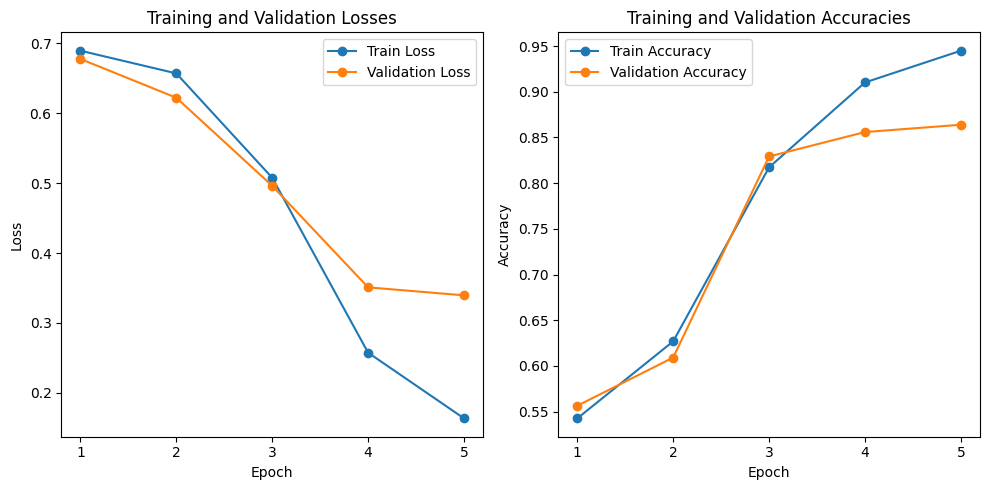

Best Validation Accuracy: 0.8638861138861139

Embedding Size: 200, Hidden Size: 512, Batch Size: 64, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.61it/s]


Epoch 1/5, Train Loss: 0.6690653546378581, Validation Loss: 0.6202800796105787, Train Accuracy: 0.623504188272836, Validation Accuracy: 0.723026973026973



Epoch 2/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.68it/s]


Epoch 2/5, Train Loss: 0.5347901550145752, Validation Loss: 0.6212750227301271, Train Accuracy: 0.7957219784603111, Validation Accuracy: 0.6750749250749251



Epoch 3/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.72it/s]


Epoch 3/5, Train Loss: 0.4044741329606615, Validation Loss: 0.4211916750246709, Train Accuracy: 0.8757977662544875, Validation Accuracy: 0.8211788211788211



Epoch 4/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.68it/s]


Epoch 4/5, Train Loss: 0.2833702525010278, Validation Loss: 0.4791500210226118, Train Accuracy: 0.9097028320702034, Validation Accuracy: 0.8446553446553446



Epoch 5/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.69it/s]


Epoch 5/5, Train Loss: 0.23297230271071992, Validation Loss: 0.48286306220930175, Train Accuracy: 0.930694056641404, Validation Accuracy: 0.8384115884115884



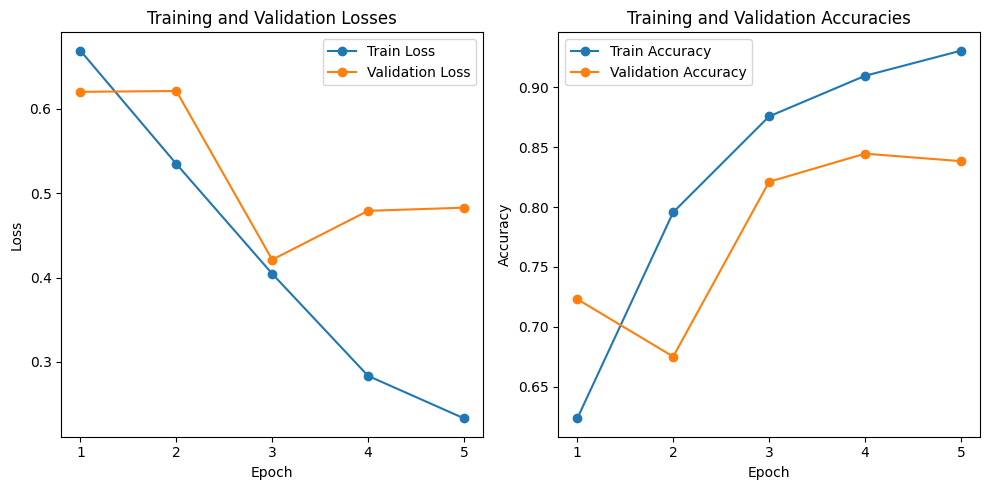

Best Validation Accuracy: 0.8446553446553446

Embedding Size: 200, Hidden Size: 512, Batch Size: 128, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


Epoch 1/5, Train Loss: 0.7081261992597181, Validation Loss: 0.694648535220654, Train Accuracy: 0.5050358994814519, Validation Accuracy: 0.5082417582417582



Epoch 2/5 (Validation): 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


Epoch 2/5, Train Loss: 0.6959813775938253, Validation Loss: 0.6922646358415678, Train Accuracy: 0.5155564419625049, Validation Accuracy: 0.5164835164835165



Epoch 3/5 (Validation): 100%|██████████| 32/32 [00:09<00:00,  3.52it/s]


Epoch 3/5, Train Loss: 0.6905925768658988, Validation Loss: 0.6891816065504358, Train Accuracy: 0.5577383326685281, Validation Accuracy: 0.5264735264735265



Epoch 4/5 (Validation): 100%|██████████| 32/32 [00:09<00:00,  3.53it/s]


Epoch 4/5, Train Loss: 0.6508511768473445, Validation Loss: 0.680042111432993, Train Accuracy: 0.6942560829676905, Validation Accuracy: 0.5354645354645354



Epoch 5/5 (Validation): 100%|██████████| 32/32 [00:09<00:00,  3.52it/s]


Epoch 5/5, Train Loss: 0.5520389348946104, Validation Loss: 0.5516445458113969, Train Accuracy: 0.7782708416433984, Validation Accuracy: 0.8104395604395604



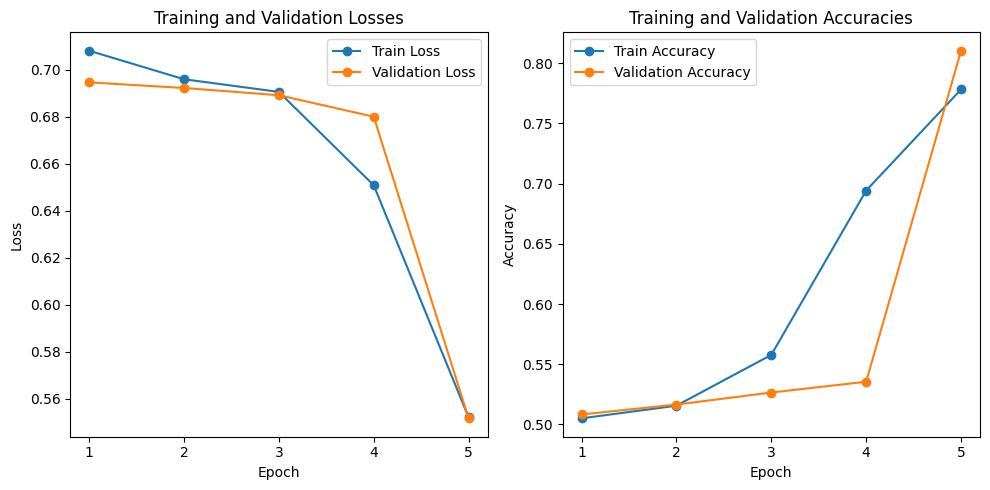

Best Validation Accuracy: 0.8104395604395604

Best Hyperparameters: {'embedding_size': 200, 'hidden_size': 512, 'batch_size': 32, 'num_layers': [1], 'learning_rate': 0.005}
Best Validation Accuracy: 0.8638861138861139


In [99]:
# Define ranges for hyperparameters
# input_size = len(word_to_idx_train)
embedding_sizes = [200]
hidden_sizes = [128, 256, 512]
batch_sizes = [32, 64, 128]
num_layers = [1] #[1, 2]
learning_rates = [0.005] #[0.001, 0.005]


# Iterate over all combinations of hyperparameters
for embedding_size, hidden_size, batch_size, num_layer, learning_rate in itertools.product(embedding_sizes, hidden_sizes, batch_sizes, num_layers, learning_rates):
    # Initialize model, criterion, and optimizer
    model = RNN(len(word_to_idx_train), embedding_size, hidden_size, num_layer, output_size).to(device)  # Move model to GPU
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    print(f"Embedding Size: {embedding_size}, Hidden Size: {hidden_size}, Batch Size: {batch_size}, Num Layers: {num_layer}, Learning Rate: {learning_rate}")
    
    # Create train and validation data loaders with current batch size
    train_dataset, train_loader = create_dataset_and_loader(train_data, word_to_idx_train, batch_size, shuffle=True)
    val_dataset, val_loader = create_dataset_and_loader(val_data, word_to_idx_train, batch_size, shuffle=False)
    
    # Train the model
    accuracy, hyperparameters, model_state = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    
    # Print results
    print(f"Best Validation Accuracy: {accuracy}")
    print()
    
    # Update best hyperparameters if current configuration performs better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparameters = hyperparameters
        best_model_state = model_state

print("Best Hyperparameters:", best_hyperparameters)
print("Best Validation Accuracy:", best_accuracy)


Embedding Size: 300, Hidden Size: 128, Batch Size: 32, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.59it/s]


Epoch 1/5, Train Loss: 0.5321435233511961, Validation Loss: 0.4945036210975685, Train Accuracy: 0.7275628240925409, Validation Accuracy: 0.7862137862137862



Epoch 2/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.70it/s]


Epoch 2/5, Train Loss: 0.28564530075499867, Validation Loss: 0.4427453167848177, Train Accuracy: 0.8918029517351416, Validation Accuracy: 0.8024475524475524



Epoch 3/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.54it/s]


Epoch 3/5, Train Loss: 0.1804137626015717, Validation Loss: 0.41633347924296316, Train Accuracy: 0.9370761866773035, Validation Accuracy: 0.8376623376623377



Epoch 4/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.49it/s]


Epoch 4/5, Train Loss: 0.10597014639156603, Validation Loss: 0.48672343062592316, Train Accuracy: 0.96405065815716, Validation Accuracy: 0.8424075924075924



Epoch 5/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.72it/s]


Epoch 5/5, Train Loss: 0.0676368425307126, Validation Loss: 0.5365215086198591, Train Accuracy: 0.9777124052652573, Validation Accuracy: 0.8274225774225774



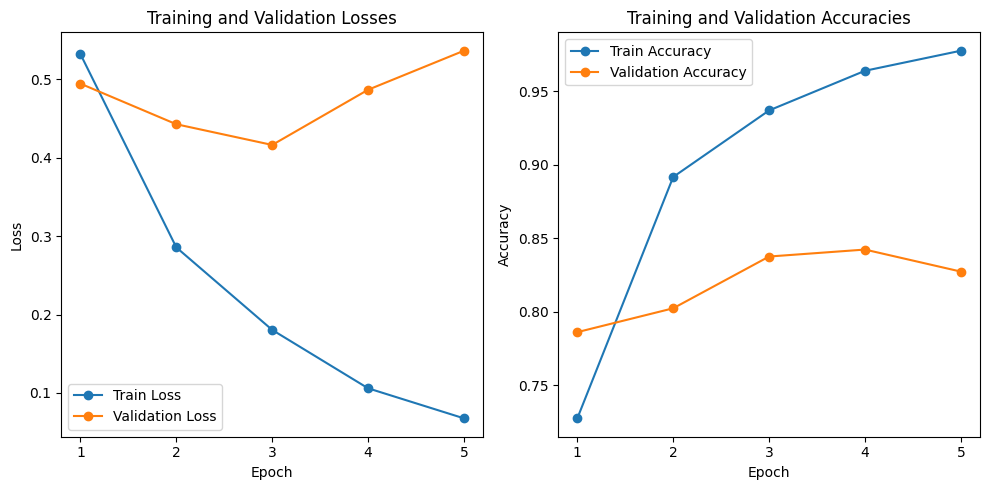

Best Validation Accuracy: 0.8424075924075924

Embedding Size: 300, Hidden Size: 128, Batch Size: 64, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.29it/s]


Epoch 1/5, Train Loss: 0.5172051651144008, Validation Loss: 0.440179026984311, Train Accuracy: 0.7443657758276825, Validation Accuracy: 0.8056943056943057



Epoch 2/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.36it/s]


Epoch 2/5, Train Loss: 0.2953698513015219, Validation Loss: 0.3844023974208565, Train Accuracy: 0.8878141204627045, Validation Accuracy: 0.8361638361638362



Epoch 3/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.30it/s]


Epoch 3/5, Train Loss: 0.15986807915999873, Validation Loss: 0.43270189999104974, Train Accuracy: 0.9424112485041882, Validation Accuracy: 0.8321678321678322



Epoch 4/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.35it/s]


Epoch 4/5, Train Loss: 0.09638677494794333, Validation Loss: 0.48348281630031115, Train Accuracy: 0.9679397686477862, Validation Accuracy: 0.8346653346653347



Epoch 5/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.36it/s]


Epoch 5/5, Train Loss: 0.06630776377709074, Validation Loss: 0.5236342066413278, Train Accuracy: 0.9770642201834863, Validation Accuracy: 0.827922077922078



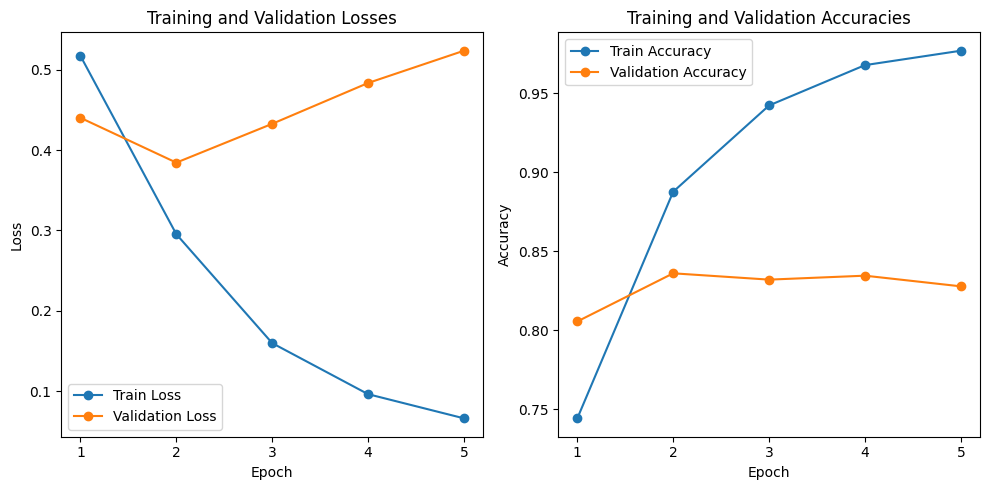

Best Validation Accuracy: 0.8361638361638362

Embedding Size: 300, Hidden Size: 128, Batch Size: 128, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 1/5, Train Loss: 0.57196736675741, Validation Loss: 0.5017798966342039, Train Accuracy: 0.71405065815716, Validation Accuracy: 0.8151848151848152



Epoch 2/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Epoch 2/5, Train Loss: 0.3308663193120108, Validation Loss: 0.4139133382153201, Train Accuracy: 0.8692161946549661, Validation Accuracy: 0.8236763236763237



Epoch 3/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 3/5, Train Loss: 0.2071224570000937, Validation Loss: 0.42822694046037657, Train Accuracy: 0.9237634623055445, Validation Accuracy: 0.8294205794205795



Epoch 4/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 4/5, Train Loss: 0.14184009654081148, Validation Loss: 0.4362325524533545, Train Accuracy: 0.9511368169126446, Validation Accuracy: 0.8284215784215784



Epoch 5/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 5/5, Train Loss: 0.0889829266972403, Validation Loss: 0.4735376117648659, Train Accuracy: 0.968986836856801, Validation Accuracy: 0.8236763236763237



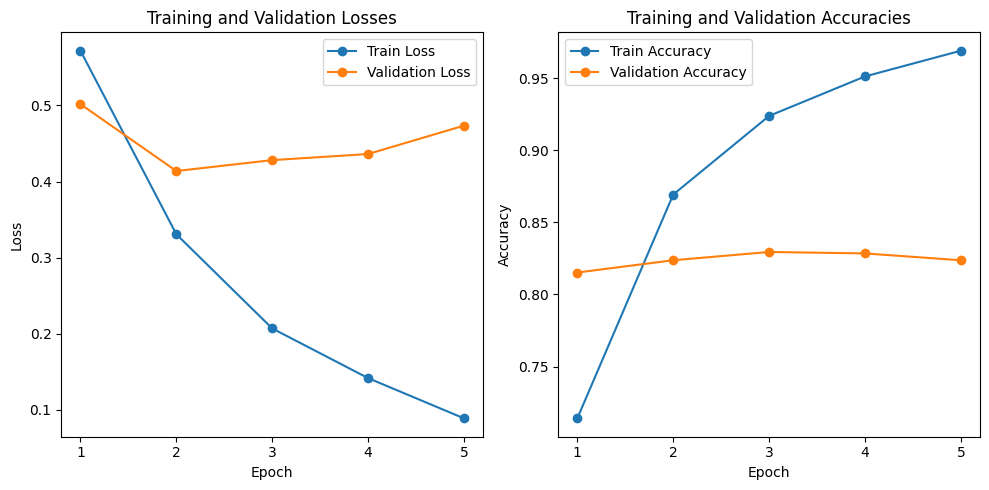

Best Validation Accuracy: 0.8294205794205795

Embedding Size: 300, Hidden Size: 256, Batch Size: 32, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 126/126 [00:09<00:00, 13.97it/s]


Epoch 1/5, Train Loss: 0.5121253925963707, Validation Loss: 0.3817222270813141, Train Accuracy: 0.7204826485839649, Validation Accuracy: 0.8366633366633367



Epoch 2/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.14it/s]


Epoch 2/5, Train Loss: 0.22419092399716425, Validation Loss: 0.3724308411677281, Train Accuracy: 0.9138911049062625, Validation Accuracy: 0.8496503496503497



Epoch 3/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.12it/s]


Epoch 3/5, Train Loss: 0.12524279443852493, Validation Loss: 0.4023017648990814, Train Accuracy: 0.95547467092142, Validation Accuracy: 0.8429070929070929



Epoch 4/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.13it/s]


Epoch 4/5, Train Loss: 0.08459494855755656, Validation Loss: 0.49607407378328666, Train Accuracy: 0.9720781810929398, Validation Accuracy: 0.8316683316683317



Epoch 5/5 (Validation): 100%|██████████| 126/126 [00:08<00:00, 14.15it/s]


Epoch 5/5, Train Loss: 0.057887825218118846, Validation Loss: 0.5953567549660728, Train Accuracy: 0.9806043079377742, Validation Accuracy: 0.8324175824175825



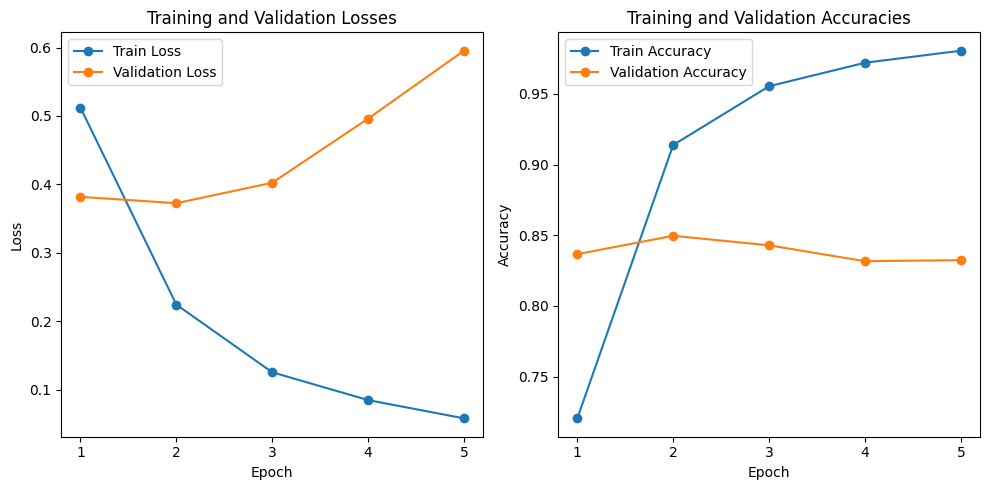

Best Validation Accuracy: 0.8496503496503497

Embedding Size: 300, Hidden Size: 256, Batch Size: 64, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.10it/s]


Epoch 1/5, Train Loss: 0.5079309558150394, Validation Loss: 0.39389271592045877, Train Accuracy: 0.737335460710012, Validation Accuracy: 0.8304195804195804



Epoch 2/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.14it/s]


Epoch 2/5, Train Loss: 0.2449185308655943, Validation Loss: 0.36820445206020025, Train Accuracy: 0.906761069006781, Validation Accuracy: 0.8511488511488512



Epoch 3/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.02it/s]


Epoch 3/5, Train Loss: 0.13692938665683688, Validation Loss: 0.510719803365675, Train Accuracy: 0.9517850019944156, Validation Accuracy: 0.8266733266733267



Epoch 4/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.07it/s]


Epoch 4/5, Train Loss: 0.09186102747828018, Validation Loss: 0.5067048318736203, Train Accuracy: 0.9715297167929796, Validation Accuracy: 0.8294205794205795



Epoch 5/5 (Validation): 100%|██████████| 63/63 [00:08<00:00,  7.14it/s]


Epoch 5/5, Train Loss: 0.0852845903763887, Validation Loss: 0.5144397394283192, Train Accuracy: 0.9763163143199043, Validation Accuracy: 0.8409090909090909



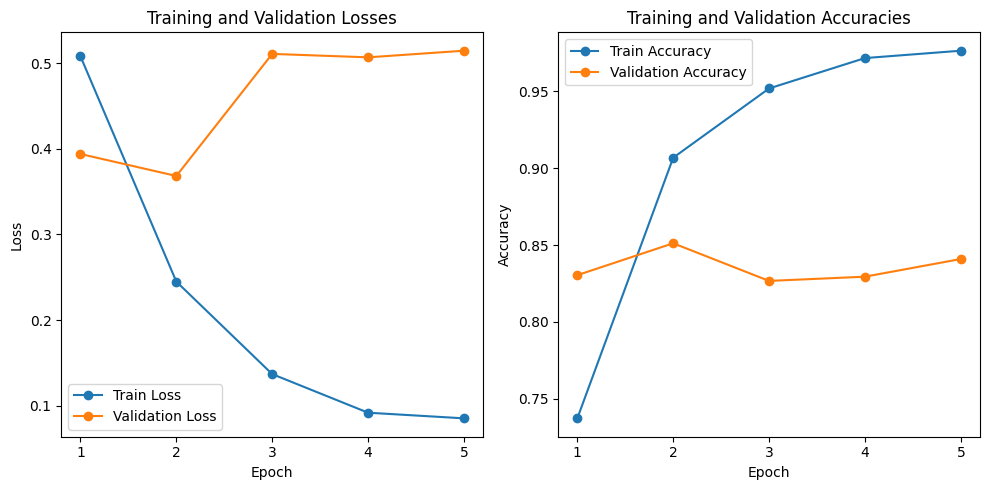

Best Validation Accuracy: 0.8511488511488512

Embedding Size: 300, Hidden Size: 256, Batch Size: 128, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


Epoch 1/5, Train Loss: 0.7055756125879992, Validation Loss: 0.6903601932477998, Train Accuracy: 0.507828081372158, Validation Accuracy: 0.49125874125874125



Epoch 2/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


Epoch 2/5, Train Loss: 0.5777777010433028, Validation Loss: 0.6083965356295163, Train Accuracy: 0.6844834463502194, Validation Accuracy: 0.6680819180819181



Epoch 3/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


Epoch 3/5, Train Loss: 0.34060776891059785, Validation Loss: 0.4124552957363776, Train Accuracy: 0.8732548863183087, Validation Accuracy: 0.8236763236763237



Epoch 4/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


Epoch 4/5, Train Loss: 0.2477046991540561, Validation Loss: 0.4408157527684927, Train Accuracy: 0.9108496210610291, Validation Accuracy: 0.8124375624375625



Epoch 5/5 (Validation): 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


Epoch 5/5, Train Loss: 0.17591549774114001, Validation Loss: 0.43991329235868615, Train Accuracy: 0.9374252094136418, Validation Accuracy: 0.8319180819180819



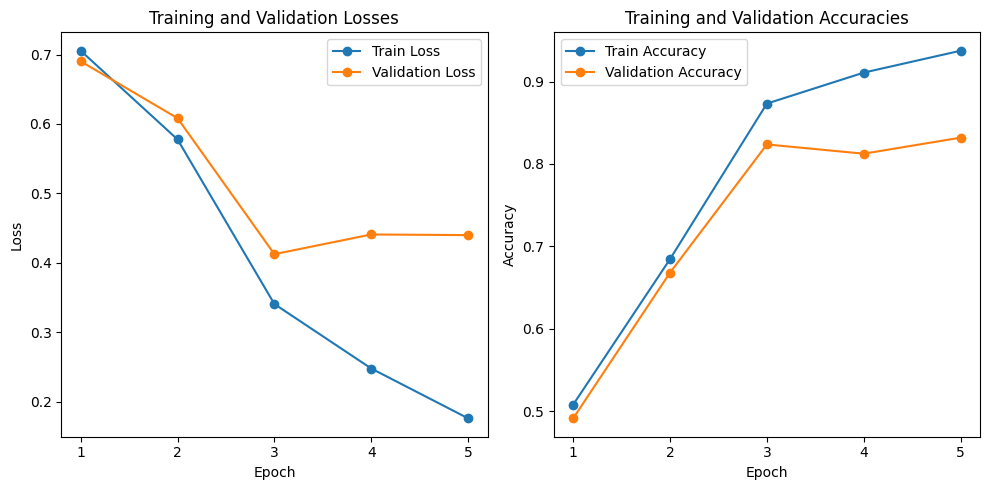

Best Validation Accuracy: 0.8319180819180819

Embedding Size: 300, Hidden Size: 512, Batch Size: 32, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 126/126 [00:10<00:00, 12.46it/s]


Epoch 1/5, Train Loss: 0.6757513377406847, Validation Loss: 0.6401702469283646, Train Accuracy: 0.598923015556442, Validation Accuracy: 0.7292707292707292



Epoch 2/5 (Validation): 100%|██████████| 126/126 [00:10<00:00, 12.20it/s]


Epoch 2/5, Train Loss: 0.6048463304465065, Validation Loss: 0.557621176843043, Train Accuracy: 0.7536896689270044, Validation Accuracy: 0.6810689310689311



Epoch 3/5 (Validation): 100%|██████████| 126/126 [00:10<00:00, 12.19it/s]


Epoch 3/5, Train Loss: 0.3900747429482909, Validation Loss: 0.4035589062012397, Train Accuracy: 0.8837255684084563, Validation Accuracy: 0.8364135864135864



Epoch 4/5 (Validation): 100%|██████████| 126/126 [00:09<00:00, 12.63it/s]


Epoch 4/5, Train Loss: 0.22174414959047056, Validation Loss: 0.4054840224070268, Train Accuracy: 0.9263562026326286, Validation Accuracy: 0.8319180819180819



Epoch 5/5 (Validation): 100%|██████████| 126/126 [00:10<00:00, 12.54it/s]


Epoch 5/5, Train Loss: 0.2308588926659954, Validation Loss: 0.3936863174507549, Train Accuracy: 0.9408655763861189, Validation Accuracy: 0.8311688311688312



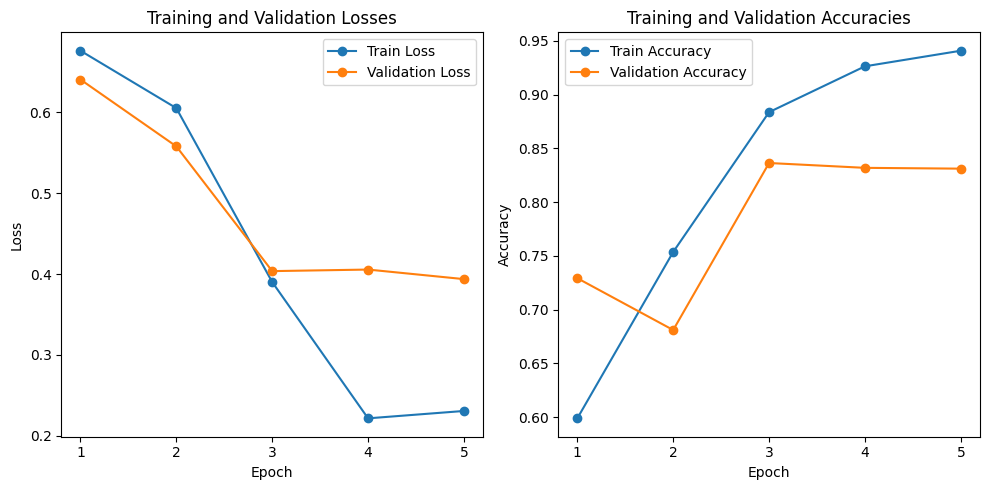

Best Validation Accuracy: 0.8364135864135864

Embedding Size: 300, Hidden Size: 512, Batch Size: 64, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.54it/s]


Epoch 1/5, Train Loss: 0.6943937344621461, Validation Loss: 0.6827307968706517, Train Accuracy: 0.5635719984044675, Validation Accuracy: 0.6868131868131868



Epoch 2/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.57it/s]


Epoch 2/5, Train Loss: 0.6152028301868203, Validation Loss: 0.6446031939971459, Train Accuracy: 0.7610191463901077, Validation Accuracy: 0.6753246753246753



Epoch 3/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.69it/s]


Epoch 3/5, Train Loss: 0.547631447230576, Validation Loss: 0.5113645649694658, Train Accuracy: 0.788093338651775, Validation Accuracy: 0.8174325674325674



Epoch 4/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.62it/s]


Epoch 4/5, Train Loss: 0.4401625673467532, Validation Loss: 0.48155145390288573, Train Accuracy: 0.8697646589549262, Validation Accuracy: 0.8116883116883117



Epoch 5/5 (Validation): 100%|██████████| 63/63 [00:09<00:00,  6.59it/s]


Epoch 5/5, Train Loss: 0.3594741170440578, Validation Loss: 0.46874928117155673, Train Accuracy: 0.8971380135620263, Validation Accuracy: 0.8141858141858141



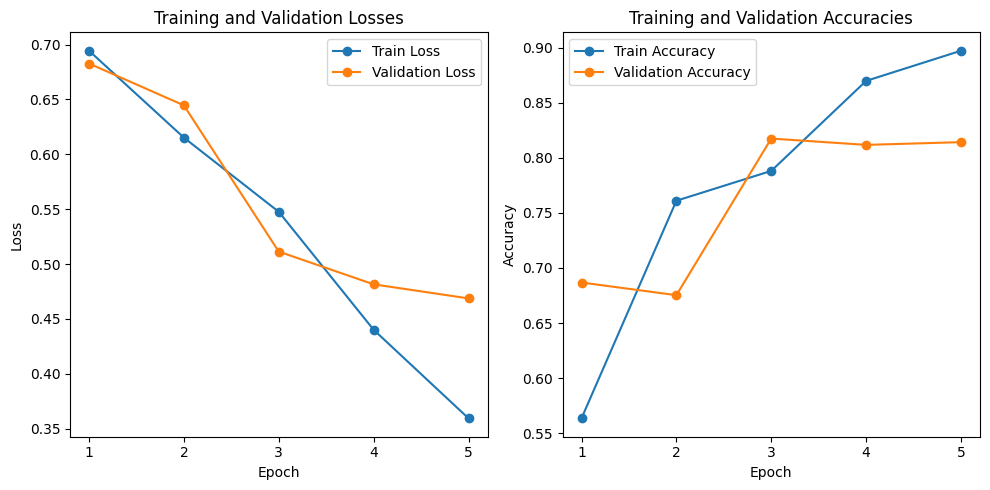

Best Validation Accuracy: 0.8174325674325674

Embedding Size: 300, Hidden Size: 512, Batch Size: 128, Num Layers: 1, Learning Rate: 0.005


Epoch 1/5 (Validation): 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


Epoch 1/5, Train Loss: 0.7186205221877233, Validation Loss: 0.7890991962753928, Train Accuracy: 0.5028420422816114, Validation Accuracy: 0.47652347652347654



Epoch 2/5 (Validation): 100%|██████████| 32/32 [00:09<00:00,  3.42it/s]


Epoch 2/5, Train Loss: 0.6458428919576866, Validation Loss: 0.5100096627906129, Train Accuracy: 0.6093438372556841, Validation Accuracy: 0.7607392607392608



Epoch 3/5 (Validation): 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


Epoch 3/5, Train Loss: 0.6127400093455214, Validation Loss: 0.68644015557997, Train Accuracy: 0.6710211408057439, Validation Accuracy: 0.5239760239760239



Epoch 4/5 (Validation): 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


Epoch 4/5, Train Loss: 0.4440865026535054, Validation Loss: 0.46807587069350404, Train Accuracy: 0.8278819305943359, Validation Accuracy: 0.7814685314685315



Epoch 5/5 (Validation): 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]


Epoch 5/5, Train Loss: 0.4581012782890767, Validation Loss: 0.6278091815563587, Train Accuracy: 0.8031013163143199, Validation Accuracy: 0.6101398601398601



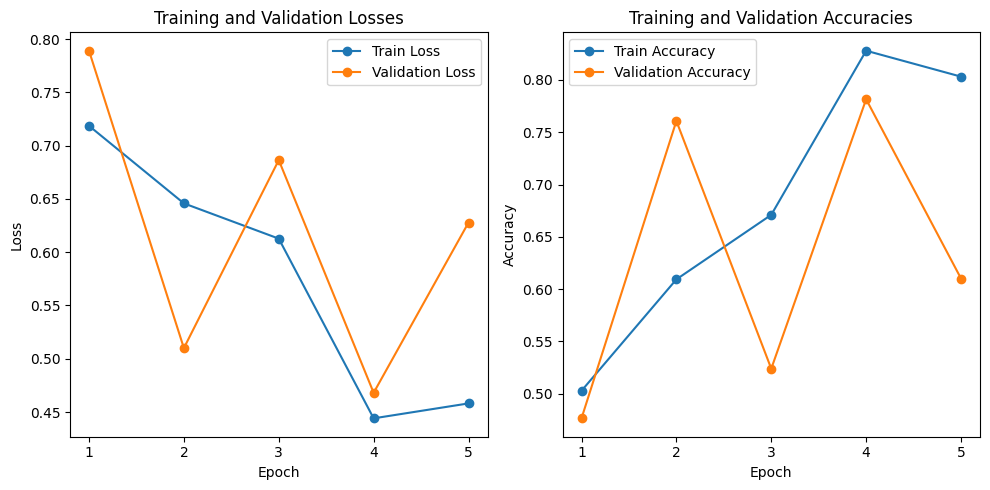

Best Validation Accuracy: 0.7814685314685315

Best Hyperparameters: {'embedding_size': 200, 'hidden_size': 512, 'batch_size': 32, 'num_layers': [1], 'learning_rate': 0.005}
Best Validation Accuracy: 0.8638861138861139


In [100]:
# Define ranges for hyperparameters
# input_size = len(word_to_idx_train)
embedding_sizes = [300]
hidden_sizes = [128, 256, 512]
batch_sizes = [32, 64, 128]
num_layers = [1] #[1, 2]
learning_rates = [0.005] #[0.001, 0.005]


# Iterate over all combinations of hyperparameters
for embedding_size, hidden_size, batch_size, num_layer, learning_rate in itertools.product(embedding_sizes, hidden_sizes, batch_sizes, num_layers, learning_rates):
    # Initialize model, criterion, and optimizer
    model = RNN(len(word_to_idx_train), embedding_size, hidden_size, num_layer, output_size).to(device)  # Move model to GPU
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    print(f"Embedding Size: {embedding_size}, Hidden Size: {hidden_size}, Batch Size: {batch_size}, Num Layers: {num_layer}, Learning Rate: {learning_rate}")
    
    # Create train and validation data loaders with current batch size
    train_dataset, train_loader = create_dataset_and_loader(train_data, word_to_idx_train, batch_size, shuffle=True)
    val_dataset, val_loader = create_dataset_and_loader(val_data, word_to_idx_train, batch_size, shuffle=False)
    
    # Train the model
    accuracy, hyperparameters, model_state = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    
    # Print results
    print(f"Best Validation Accuracy: {accuracy}")
    print()
    
    # Update best hyperparameters if current configuration performs better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparameters = hyperparameters
        best_model_state = model_state

print("Best Hyperparameters:", best_hyperparameters)
print("Best Validation Accuracy:", best_accuracy)


In [101]:
# Testing function
def test_model(model, test_loader, device):
    model.to(device)
    model.eval()
#     test_accuracies = []
    correct = 0
    total = 0
    with torch.no_grad():
        progress_bar_test = tqdm(test_loader, desc='Testing')
        for inputs, labels in progress_bar_test:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
#             test_accuracies.append(correct / total)
    
#     # Plotting the testing accuracy graph
#     plt.figure(figsize=(10, 5))
#     plt.plot(test_accuracies, marker='o', label='Test Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Testing Accuracy')
#     plt.legend()plt.xticks(range(1, num_epochs + 1))
#     plt.show()

#     return test_accuracies
    test_accuracy = correct / total  
    print(f'Test Accuracy: {test_accuracy}')

In [104]:
best_model_path = 'best_model.pt'  # Path to save the best model
# Save the best model's state dictionary to a file
if best_model_state:
    torch.save(best_model_state, best_model_path)
print()
print("Best Hyperparameters:", best_hyperparameters)
# print("Best Validation Loss:", best_validation_loss)
print()
# Load the best model for testing
best_model = RNN(len(word_to_idx_train), best_hyperparameters['embedding_size'], best_hyperparameters['hidden_size'], best_hyperparameters['num_layers'], output_size).to(device)
best_model.load_state_dict(torch.load(best_model_path))

# Test the model
test_model(best_model, test_loader, device)


Best Hyperparameters: {'embedding_size': 200, 'hidden_size': 512, 'batch_size': 32, 'num_layers': [1], 'learning_rate': 0.005}
Best Validation Loss: inf



Testing: 100%|██████████| 501/501 [00:39<00:00, 12.67it/s]


Test Accuracy: 0.8605493133583021


**Best Hyperparameters:** {'embedding_size': 200, 'hidden_size': 512, 'batch_size': 32, 'num_layers': 1, 'learning_rate': 0.005}

**Best Validation Loss:** 0.3742440557860947

**Validation Accuracy:** 0.8605493133583021

### 3. After RNNs
#### 3.1 Keeping all the parameters same, replace the RNN layer with the LSTM layer using nn.LSTM. What changes do you observe ? Explain why LSTM layer would affect performance.

In [83]:
class LSTM1(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, output_size):
        super(LSTM1, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Output size is 1 for binary classification
        self.hidden_size = hidden_size

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        # Take the output from the last time step of the last layer
#         last_output = output[:, -1, :]
#         return output.squeeze(1)  # Ensure output shape is [batch_size]
#         output = output.contiguous().view(-1, self.hidden_size)
        logits = self.fc(hidden[-1][0])
        return logits


In [84]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        for inputs, labels in progress_bar_train:
#             print(inputs.size(), labels.size())
            inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
#             print(outputs.size(), labels.size())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
#             progress_bar_train.set_postfix({'train_loss': train_loss / len(train_loader.dataset)})
            
            # Calculate training accuracy
            predicted_train = torch.round(torch.sigmoid(outputs))
#             _, predicted_train = torch.max(outputs, 1)
    
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
#             print(predicted_train)
#             print(labels) 
#             print(correct_train)
#             break
            
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
            for inputs, labels in progress_bar_val:
                inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                predicted_val = torch.round(torch.sigmoid(outputs))
#                 _, predicted_val = torch.max(outputs, 1)
    
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_accuracy}')

    # Plot the losses and accuracies
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.xticks(range(1, num_epochs + 1))

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.xticks(range(1, num_epochs + 1))

    plt.tight_layout()
    plt.show()

    

# Testing function
def test_model(model, test_loader, device):
    model.to(device)
    model.eval()
#     test_accuracies = []
    correct = 0
    total = 0
    with torch.no_grad():
        progress_bar_test = tqdm(test_loader, desc='Testing')
        for inputs, labels in progress_bar_test:
            inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs))
#             _, predicted = torch.max(outputs, 1)
    
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
#             test_accuracies.append(correct / total)
    
#     # Plotting the testing accuracy graph
#     plt.figure(figsize=(10, 5))
#     plt.plot(test_accuracies, marker='o', label='Test Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Testing Accuracy')
#     plt.legend()plt.xticks(range(1, num_epochs + 1))
#     plt.show()

#     return test_accuracies
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy}')


In [85]:
# Hyperparameters
embedding_size = 100
hidden_size = 128
num_layers = 1
output_size = 1  # For binary classification
learning_rate = 0.005
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# input_size = len(word_to_idx_train)


In [86]:
def ModelToRun4(input_size, embedding_size, hidden_size, num_layers, output_size, device, train_loader, val_loader, num_epochs, test_loader):
    # Initialize model, criterion, and optimizer
    model4 = LSTM1(input_size, embedding_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits
    optimizer = optim.Adam(model4.parameters(), lr=learning_rate)
    # Train the model2
    train_model(model4, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    # Test the model
    test_model(model4, test_loader, device)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.34it/s]


Epoch 1/5, Train Loss: 0.6944972540831061, Val Loss: 0.6928813312794422, Val Acc: 0.5102397602397603


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.59it/s]


Epoch 2/5, Train Loss: 0.6858809951010766, Val Loss: 0.8174997881933168, Val Acc: 0.6206293706293706


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.70it/s]


Epoch 3/5, Train Loss: 0.4798039899530475, Val Loss: 0.34589129510697547, Val Acc: 0.8556443556443556


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.23it/s]


Epoch 4/5, Train Loss: 0.19801563365250457, Val Loss: 0.32642227706018384, Val Acc: 0.8643856143856143


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.22it/s]


Epoch 5/5, Train Loss: 0.07309650552972087, Val Loss: 0.46625881705369865, Val Acc: 0.8648851148851149


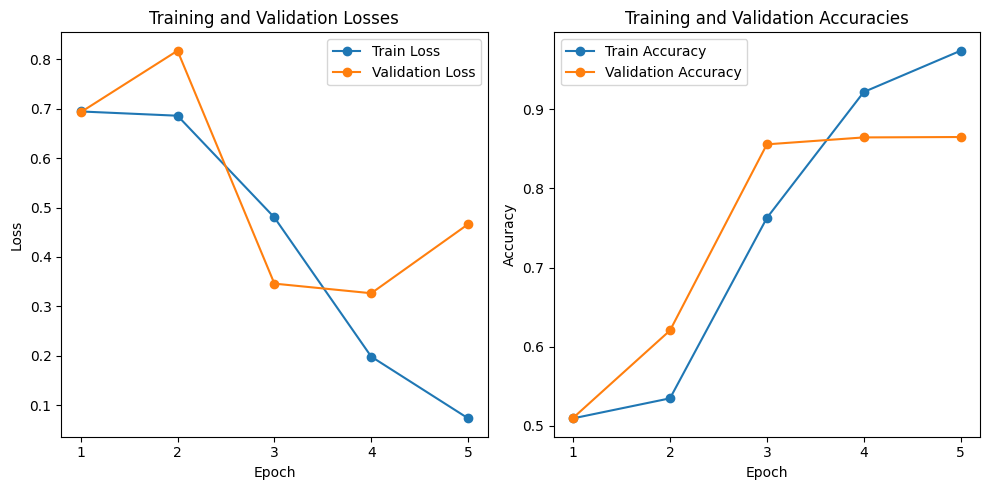

Testing: 100%|██████████| 501/501 [00:38<00:00, 13.02it/s]

Test Accuracy: 0.8650436953807741


In [63]:
ModelToRun4(len(word_to_idx_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader, val_loader, num_epochs, test_loader)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:23<00:00,  5.31it/s]


Epoch 1/5, Train Loss: 0.6968624068057817, Val Loss: 0.6929879107556262, Val Acc: 0.5094905094905094


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:23<00:00,  5.27it/s]


Epoch 2/5, Train Loss: 0.692985438544483, Val Loss: 0.6934518679514989, Val Acc: 0.5094905094905094


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:23<00:00,  5.27it/s]


Epoch 3/5, Train Loss: 0.6929434734746951, Val Loss: 0.6931852825157173, Val Acc: 0.4905094905094905


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.21it/s]


Epoch 4/5, Train Loss: 0.6931489998713213, Val Loss: 0.6930230853559969, Val Acc: 0.5094905094905094


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.16it/s]


Epoch 5/5, Train Loss: 0.6930943172578085, Val Loss: 0.693537974988783, Val Acc: 0.4905094905094905


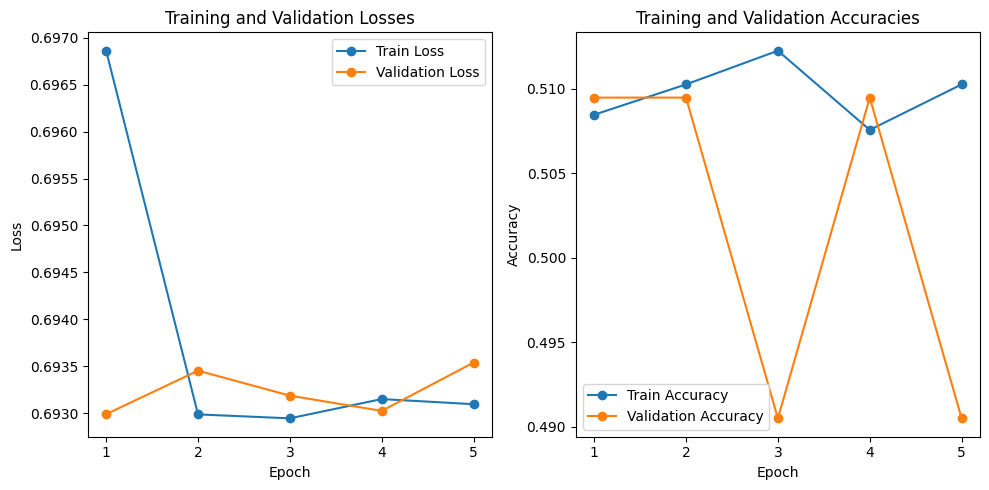

Testing: 100%|██████████| 501/501 [01:37<00:00,  5.15it/s]

Test Accuracy: 0.49113607990012487


In [87]:
ModelToRun4(len(word_to_idx_stem_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader_stem, val_loader_stem, num_epochs, test_loader_stem)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.70it/s]


Epoch 1/5, Train Loss: 0.6979231304222718, Val Loss: 0.6929682790935338, Val Acc: 0.5094905094905094


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.67it/s]


Epoch 2/5, Train Loss: 0.6934656490592972, Val Loss: 0.6931738989217417, Val Acc: 0.5094905094905094


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.64it/s]


Epoch 3/5, Train Loss: 0.6930804302552614, Val Loss: 0.6929700948618033, Val Acc: 0.5094905094905094


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.67it/s]


Epoch 4/5, Train Loss: 0.6930050065805582, Val Loss: 0.6929676154633978, Val Acc: 0.5094905094905094


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 11.02it/s]


Epoch 5/5, Train Loss: 0.6930331816034199, Val Loss: 0.6929935303839532, Val Acc: 0.5094905094905094


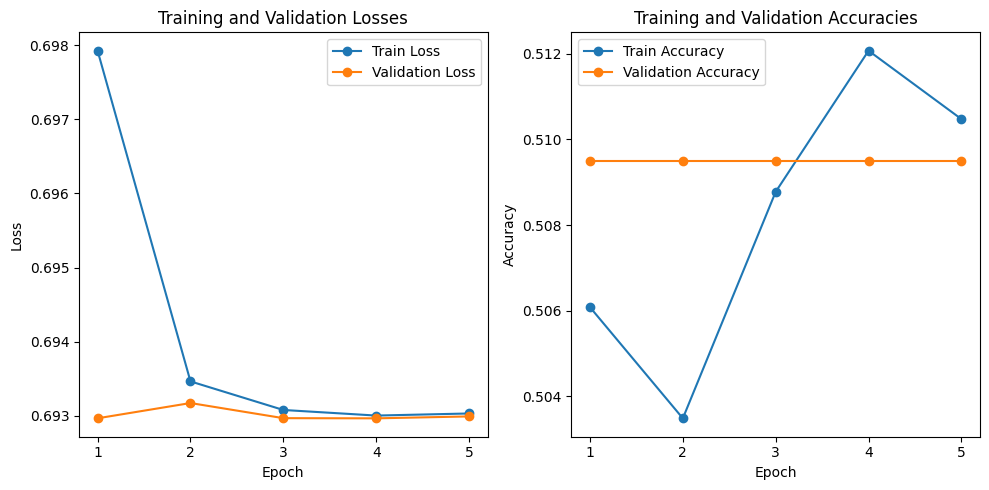

Testing: 100%|██████████| 501/501 [00:46<00:00, 10.75it/s]

Test Accuracy: 0.5088639200998751


In [88]:
ModelToRun4(len(word_to_idx_lemm_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader_lemm, val_loader_lemm, num_epochs, test_loader_lemm)

In [89]:
class LSTM2(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, output_size):
        super(LSTM2, self).__init__()  # Corrected super() call
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)  # Replaced RNN with LSTM
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        # Take the output from the last time step of the last layer
        last_output = output[:, -1, :]
        output = self.fc(last_output)
        return output.squeeze(1)  # Squeeze to make output shape (batch_size,)

In [65]:
# # Training function
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
#     model.to(device)
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.float().to(device)  # Convert labels to float
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * inputs.size(0)

#         train_loss /= len(train_loader.dataset)

#         # Validation
#         model.eval()
#         val_loss = 0.0
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.float().to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item() * inputs.size(0)

#                 # Apply sigmoid activation and round to get predictions
#                 predicted = torch.round(torch.sigmoid(outputs))

#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         val_loss /= len(val_loader.dataset)
#         val_accuracy = correct / total

#         print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_accuracy}')


# # Testing function
# def test_model(model, test_loader, device):
#     model.to(device)
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.float().to(device)  # Convert labels to float
#             outputs = model(inputs)
#             predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid activation and round to get predictions
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     test_accuracy = correct / total
#     print(f'Test Accuracy: {test_accuracy}')

In [90]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        for inputs, labels in progress_bar_train:
            inputs, labels = inputs.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
#             progress_bar_train.set_postfix({'train_loss': train_loss / len(train_loader.dataset)})
            
            # Calculate training accuracy
            predicted_train = torch.round(torch.sigmoid(outputs))
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
            for inputs, labels in progress_bar_val:
                inputs, labels = inputs.to(device), labels.float().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                predicted_val = torch.round(torch.sigmoid(outputs))

                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_accuracy}')

    # Plot the losses and accuracies
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.xticks(range(1, num_epochs + 1))

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.xticks(range(1, num_epochs + 1))

    plt.tight_layout()
    plt.show()

    

# Testing function
def test_model(model, test_loader, device):
    model.to(device)
    model.eval()
#     test_accuracies = []
    correct = 0
    total = 0
    with torch.no_grad():
        progress_bar_test = tqdm(test_loader, desc='Testing')
        for inputs, labels in progress_bar_test:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
#             test_accuracies.append(correct / total)
    
#     # Plotting the testing accuracy graph
#     plt.figure(figsize=(10, 5))
#     plt.plot(test_accuracies, marker='o', label='Test Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Testing Accuracy')
#     plt.legend()plt.xticks(range(1, num_epochs + 1))
#     plt.show()

#     return test_accuracies
    test_accuracy = correct / total  
    print(f'Test Accuracy: {test_accuracy}')


In [91]:
# Hyperparameters
# input_size = len(word_to_idx_train)
embedding_size = 100
hidden_size = 128
num_layers = 1  # Adjusted for simplicity
output_size = 1  # Output size changed to 1 for binary classification
learning_rate = 0.005
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [92]:
def ModelToRun5(input_size, embedding_size, hidden_size, num_layers, output_size, device, train_loader, val_loader, num_epochs, test_loader):
    # Initialize model, criterion, and optimizer
    model5 = LSTM2(input_size, embedding_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits
    optimizer = optim.Adam(model5.parameters(), lr=learning_rate)
    # Train the model2
    train_model(model5, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    # Test the model
    test_model(model5, test_loader, device)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.12it/s]


Epoch 1/5, Train Loss: 0.6939181800520082, Val Loss: 0.69281204787644, Val Acc: 0.5102397602397603


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.03it/s]


Epoch 2/5, Train Loss: 0.6918790368953929, Val Loss: 0.6931744242881561, Val Acc: 0.5107392607392608


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.10it/s]


Epoch 3/5, Train Loss: 0.6884888170437837, Val Loss: 0.6952893577970111, Val Acc: 0.5102397602397603


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.08it/s]


Epoch 4/5, Train Loss: 0.6495362750362674, Val Loss: 0.5485582394557043, Val Acc: 0.7347652347652348


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.09it/s]


Epoch 5/5, Train Loss: 0.4551168088424144, Val Loss: 0.4726225721252548, Val Acc: 0.7887112887112887


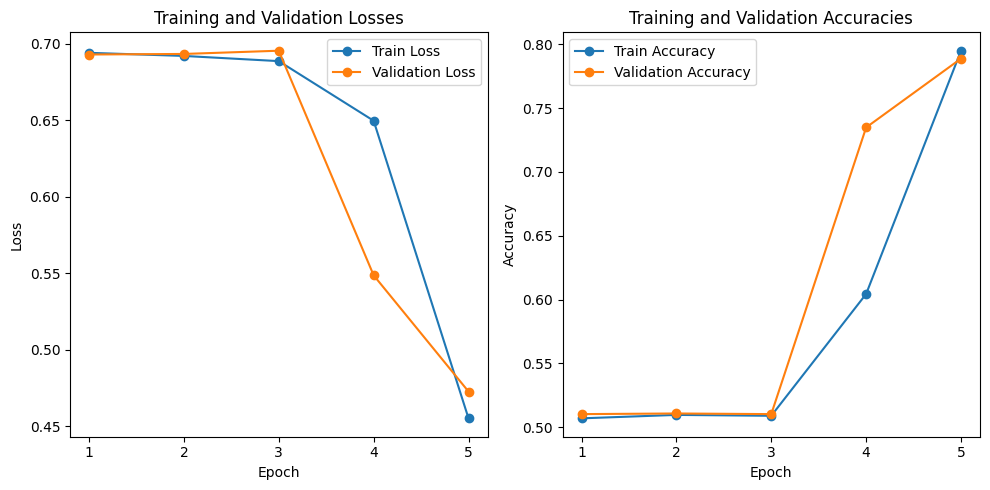

Testing: 100%|██████████| 501/501 [00:37<00:00, 13.23it/s]

Test Accuracy: 0.7849563046192259


In [69]:
ModelToRun5(len(word_to_idx_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader, val_loader, num_epochs, test_loader)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:23<00:00,  5.31it/s]


Epoch 1/5, Train Loss: 0.6938458498036857, Val Loss: 0.6930094008202796, Val Acc: 0.5094905094905094


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:23<00:00,  5.30it/s]


Epoch 2/5, Train Loss: 0.692993466151298, Val Loss: 0.6929798855648174, Val Acc: 0.5094905094905094


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:23<00:00,  5.31it/s]


Epoch 3/5, Train Loss: 0.693050078010483, Val Loss: 0.6929742636737767, Val Acc: 0.5094905094905094


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:23<00:00,  5.31it/s]


Epoch 4/5, Train Loss: 0.6930034041975331, Val Loss: 0.6929683792483914, Val Acc: 0.5094905094905094


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.24it/s]


Epoch 5/5, Train Loss: 0.6929121287781069, Val Loss: 0.6929679075916568, Val Acc: 0.5094905094905094


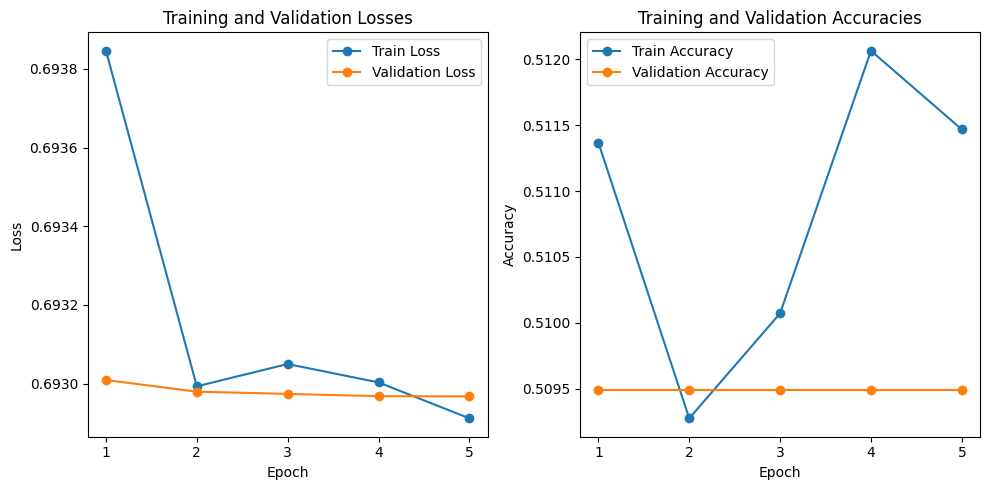

Testing: 100%|██████████| 501/501 [01:35<00:00,  5.26it/s]

Test Accuracy: 0.5088639200998751


In [93]:
ModelToRun5(len(word_to_idx_stem_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader_stem, val_loader_stem, num_epochs, test_loader_stem)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.66it/s]


Epoch 1/5, Train Loss: 0.6938944799185846, Val Loss: 0.6931226698906867, Val Acc: 0.5094905094905094


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.63it/s]


Epoch 2/5, Train Loss: 0.6929462629815807, Val Loss: 0.6931563410963807, Val Acc: 0.5094905094905094


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.57it/s]


Epoch 3/5, Train Loss: 0.6930510243857863, Val Loss: 0.6930211703855913, Val Acc: 0.5094905094905094


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.86it/s]


Epoch 4/5, Train Loss: 0.6930205201931479, Val Loss: 0.693286157928623, Val Acc: 0.5094905094905094


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.97it/s]


Epoch 5/5, Train Loss: 0.6929600333425692, Val Loss: 0.6929911932387909, Val Acc: 0.5094905094905094


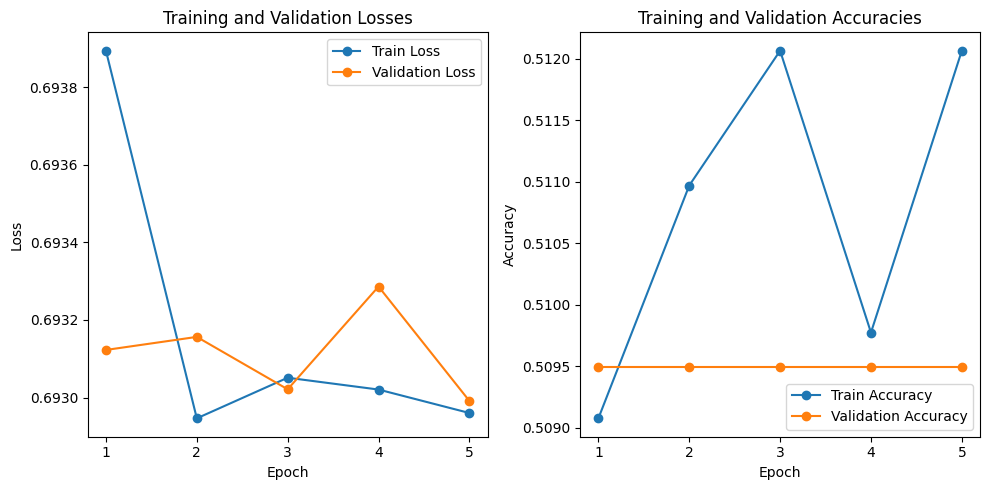

Testing: 100%|██████████| 501/501 [00:46<00:00, 10.79it/s]

Test Accuracy: 0.5088639200998751


In [94]:
ModelToRun5(len(word_to_idx_lemm_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader_lemm, val_loader_lemm, num_epochs, test_loader_lemm)

In [70]:
class LSTM3(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, output_size):
        super(LSTM3, self).__init__()  # Corrected super() call
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)  # Replaced RNN with LSTM
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output_mean = torch.mean(output, dim=1)
        output = self.fc(output_mean)
        return output.squeeze(1)  # Ensure output shape is [batch_size]

In [71]:
# # Training function
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
#     model.to(device)
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.float().to(device)  # Convert labels to float
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * inputs.size(0)

#         train_loss /= len(train_loader.dataset)

#         # Validation
#         model.eval()
#         val_loss = 0.0
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.float().to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item() * inputs.size(0)

#                 # Apply sigmoid activation and round to get predictions
#                 predicted = torch.round(torch.sigmoid(outputs))

#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         val_loss /= len(val_loader.dataset)
#         val_accuracy = correct / total

#         print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_accuracy}')


# # Testing function
# def test_model(model, test_loader, device):
#     model.to(device)
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.float().to(device)  # Convert labels to float
#             outputs = model(inputs)
#             predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid activation and round to get predictions
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     test_accuracy = correct / total
#     print(f'Test Accuracy: {test_accuracy}')

In [72]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        for inputs, labels in progress_bar_train:
            inputs, labels = inputs.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
#             progress_bar_train.set_postfix({'train_loss': train_loss / len(train_loader.dataset)})
            
            # Calculate training accuracy
            predicted_train = torch.round(torch.sigmoid(outputs))
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
            for inputs, labels in progress_bar_val:
                inputs, labels = inputs.to(device), labels.float().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                predicted_val = torch.round(torch.sigmoid(outputs))

                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Acc: {val_accuracy}')

    # Plot the losses and accuracies
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.xticks(range(1, num_epochs + 1))

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.xticks(range(1, num_epochs + 1))

    plt.tight_layout()
    plt.show()

    

# Testing function
def test_model(model, test_loader, device):
    model.to(device)
    model.eval()
#     test_accuracies = []
    correct = 0
    total = 0
    with torch.no_grad():
        progress_bar_test = tqdm(test_loader, desc='Testing')
        for inputs, labels in progress_bar_test:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
#             test_accuracies.append(correct / total)
    
#     # Plotting the testing accuracy graph
#     plt.figure(figsize=(10, 5))
#     plt.plot(test_accuracies, marker='o', label='Test Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Testing Accuracy')
#     plt.legend()plt.xticks(range(1, num_epochs + 1))
#     plt.show()

#     return test_accuracies
    test_accuracy = correct / total  
    print(f'Test Accuracy: {test_accuracy}')


In [73]:
# Hyperparameters
# input_size = len(word_to_idx_train)
embedding_size = 100
hidden_size = 128
num_layers = 1  # Adjusted for simplicity
output_size = 1  # Output size changed to 1 for binary classification
learning_rate = 0.005
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [74]:
def ModelToRun6(input_size, embedding_size, hidden_size, num_layers, output_size, device, train_loader, val_loader, num_epochs, test_loader):
    # Initialize model, criterion, and optimizer
    model6 = LSTM3(input_size, embedding_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits
    optimizer = optim.Adam(model6.parameters(), lr=learning_rate)
    # Train the model2
    train_model(model6, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    # Test the model
    test_model(model6, test_loader, device)
    

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.07it/s]


Epoch 1/5, Train Loss: 0.41362543285820275, Val Loss: 0.2978170169042898, Val Acc: 0.8761238761238761


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.20it/s]


Epoch 2/5, Train Loss: 0.15947566385294368, Val Loss: 0.3677810566959443, Val Acc: 0.8566433566433567


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.19it/s]


Epoch 3/5, Train Loss: 0.06087359558088065, Val Loss: 0.38992602856723696, Val Acc: 0.8708791208791209


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 13.37it/s]


Epoch 4/5, Train Loss: 0.024406740649859263, Val Loss: 0.5478511973843351, Val Acc: 0.8658841158841158


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:09<00:00, 12.92it/s]


Epoch 5/5, Train Loss: 0.011617273275820222, Val Loss: 0.7054842338189259, Val Acc: 0.8581418581418582


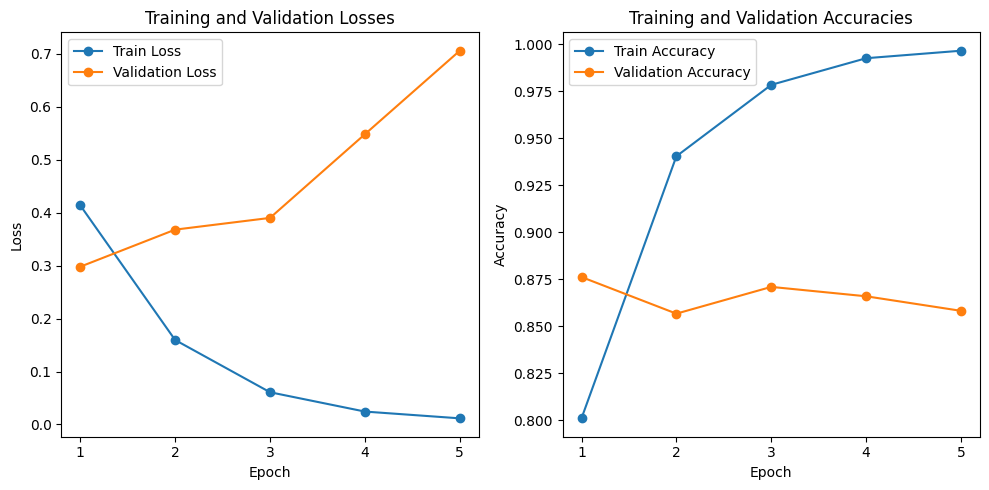

Testing: 100%|██████████| 501/501 [00:37<00:00, 13.36it/s]

Test Accuracy: 0.8614232209737828


In [75]:
ModelToRun6(len(word_to_idx_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader, val_loader, num_epochs, test_loader)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.22it/s]


Epoch 1/5, Train Loss: 0.5058144672391517, Val Loss: 0.4534190248448651, Val Acc: 0.7904595404595405


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.24it/s]


Epoch 2/5, Train Loss: 0.22957872956884207, Val Loss: 0.3593950912869953, Val Acc: 0.8451548451548452


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.11it/s]


Epoch 3/5, Train Loss: 0.13157920639829707, Val Loss: 0.43041081745903215, Val Acc: 0.8361638361638362


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.18it/s]


Epoch 4/5, Train Loss: 0.07597054030963914, Val Loss: 0.5142366767611604, Val Acc: 0.8449050949050949


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:24<00:00,  5.21it/s]


Epoch 5/5, Train Loss: 0.048940704017654685, Val Loss: 0.5093977402441657, Val Acc: 0.8506493506493507


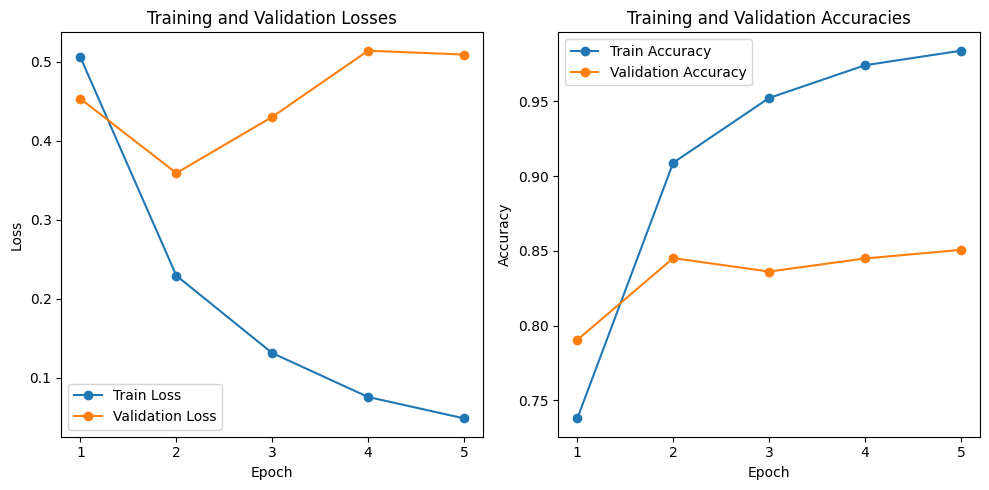

Testing: 100%|██████████| 501/501 [01:35<00:00,  5.23it/s]

Test Accuracy: 0.8440699126092385


In [81]:
ModelToRun6(len(word_to_idx_stem_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader_stem, val_loader_stem, num_epochs, test_loader_stem)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.86it/s]


Epoch 1/5, Train Loss: 0.5605525258864641, Val Loss: 0.4358161237094548, Val Acc: 0.810939060939061


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.67it/s]


Epoch 2/5, Train Loss: 0.26721082024475373, Val Loss: 0.39631832802629136, Val Acc: 0.8374125874125874


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.73it/s]


Epoch 3/5, Train Loss: 0.1426594880415854, Val Loss: 0.4035471557647913, Val Acc: 0.8454045954045954


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.80it/s]


Epoch 4/5, Train Loss: 0.083634840927076, Val Loss: 0.5055076526208119, Val Acc: 0.8513986013986014


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:11<00:00, 10.77it/s]


Epoch 5/5, Train Loss: 0.04546566763547285, Val Loss: 0.5335367513740515, Val Acc: 0.8364135864135864


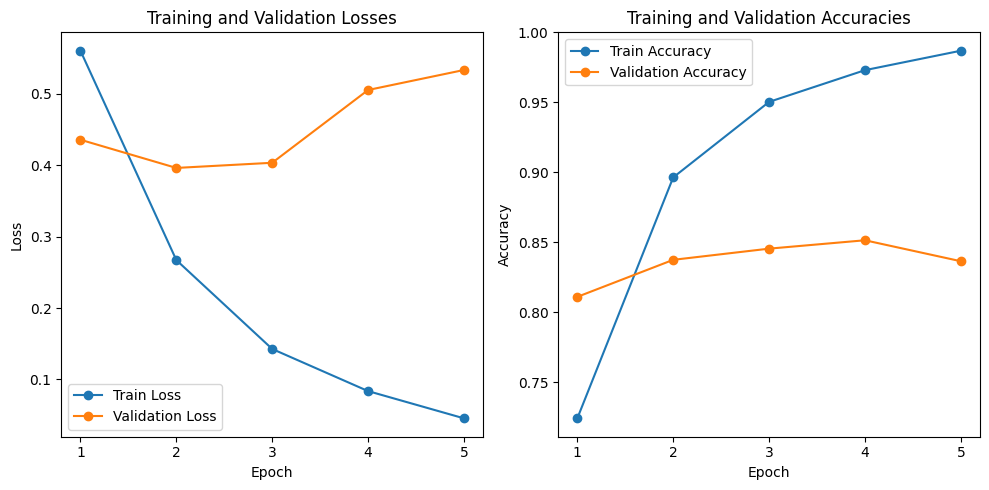

Testing: 100%|██████████| 501/501 [00:46<00:00, 10.73it/s]

Test Accuracy: 0.8389513108614233


In [82]:
ModelToRun6(len(word_to_idx_lemm_train), embedding_size, hidden_size, num_layers, output_size, device, train_loader_lemm, val_loader_lemm, num_epochs, test_loader_lemm)

In [105]:
!ls -plia

total 377780
   786438 drwxr-xr-x 5 root root      4096 Apr  6 18:43 ./
271237109 drwxr-xr-x 5 root root      4096 Apr  6 14:30 ../
   786519 drwxr-xr-x 2 root root      4096 Apr  6 14:30 .virtual_documents/
   786520 -rw-r--r-- 1 root root  53494696 Apr  6 18:45 best_model.pt
   786439 drwxr-xr-x 3 root root      4096 Apr  6 14:30 corpora/
   786517 -rw-r--r-- 1 root root 333326489 Apr  6 14:30 state.db
   786451 drwxr-xr-x 3 root root      4096 Apr  6 14:30 tokenizers/
